In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *

import matplotlib.pyplot as plt
%matplotlib inline

from multiprocess import Pool

Setting environment for Gordon


In [2]:
dataset_name = 'largeCells'

In [3]:
cell_data_dir = create_if_not_exists('/home/yuncong/csd395/CSHL_cells_v2/processed_cells')

In [4]:
n_nystrom_samples = 100

embeddings = bp.unpack_ndarray_file(cell_data_dir + '/embeddings_%(dataset_name)s_nystromSample%(n_samples)d.bp' % \
                                   {'dataset_name': dataset_name, 'n_samples': n_nystrom_samples})

In [5]:
from scipy.spatial.distance import cdist

In [6]:
def parallel_cdist(data1, data2, n_rows_per_job=100):
    pool = Pool(12)
    
    start_indices = np.arange(0, data1.shape[0], n_rows_per_job)
    end_indices = start_indices + n_rows_per_job - 1
    
    partial_distance_matrices = pool.map(lambda (si, ei): cdist(data1[si:ei+1].copy(), data2), zip(start_indices, end_indices))
    pool.close()
    pool.join()
    
    distance_matrix = np.concatenate(partial_distance_matrices)
    return distance_matrix

In [7]:
def kmeans(data, seed_indices, n_iter=100):
    
    n_classes = len(seed_indices)
    n_data = len(data)
    
    centroids = data[seed_indices]
    for i in range(n_iter):
        print i
        point_centroid_distances = parallel_cdist(data, centroids)
        
        if i > 0:
            prev_nearest_centroid_indices = nearest_centroid_indices.copy()
        
        nearest_centroid_indices = np.argmin(point_centroid_distances, axis=1)
        
        if i > 0:
            n_change = np.count_nonzero(prev_nearest_centroid_indices != nearest_centroid_indices)
            change_ratio = float(n_change) / n_data
        
            if change_ratio < .01:
                break
        
        centroids = [data[nearest_centroid_indices == c].mean(axis=0) for c in range(n_classes)]

    return nearest_centroid_indices, np.asarray(centroids)

In [8]:
kmeanspp_seeds = bp.unpack_ndarray_file(cell_data_dir + '/%(dataset_name)s_kmeansppCenters_cutoff70.bp' % \
                    {'dataset_name': dataset_name})

kmeanspp_closest_seed = bp.unpack_ndarray_file(cell_data_dir + '/%(dataset_name)s_closestKmeansppCenters_cutoff70.bp' % \
                    {'dataset_name': dataset_name})

In [16]:
t = time.time()
class_label, centroids = kmeans(embeddings, seed_indices=kmeanspp_seeds)
sys.stderr.write('%d seconds' % (time.time() - t))

0
1
2
3
4
5
6
7


224 seconds

In [17]:
bp.pack_ndarray_file(class_label, cell_data_dir + '/%(dataset_name)s_kmeansClassLabel.bp' % \
                     {'dataset_name': dataset_name})

In [18]:
print 'After kmeans,', len(np.where(class_label == kmeanspp_closest_seed)[0]), 'out of', len(class_label), \
'samples belong to the same centroid as at kmeans++ initialization.'

After kmeans, 99616 out of 204937 samples belong to the same centroid as at kmeans++ initialization.


In [9]:
class_label = bp.unpack_ndarray_file(cell_data_dir + '/%(dataset_name)s_kmeansClassLabel.bp' % \
                     {'dataset_name': dataset_name})

In [10]:
cells_aligned_padded = bp.unpack_ndarray_file(cell_data_dir + '/cells_aligned_padded.bp')
n_cells = len(cells_aligned_padded)

In [149]:
dataset_cell_indices = bp.unpack_ndarray_file(os.path.join(cell_data_dir, \
                                        '%(dataset_name)s_indices_cutoff70.bp' % {'dataset_name': dataset_name}))
dataset_cells_aligned_padded = cells_aligned_padded[dataset_cell_indices]

In [12]:
n_dataset_cells, cell_h, cell_w = dataset_cells_aligned_padded.shape

In [13]:
class_label.shape

(204937,)

In [15]:
cell_addresses = pickle.load(open(cell_data_dir + '/cell_addresses.bp', 'r'))

dataset_cell_addresses = [cell_addresses[i] for i in dataset_cell_indices]

In [17]:
filename_to_section, section_to_filename = DataManager.load_sorted_filenames(stack='MD589')

In [19]:
first_bs_section, last_bs_section = DataManager.load_cropbox(stack='MD589')[4:]

In [20]:
detected_cells_dir = '/home/yuncong/csd395/CSHL_cells_v2/detected_cells/' + 'MD589'

In [21]:
cell_orientations = {}
cell_majorAxisLens = {}
cell_minorAxisLens = {}

for sec in range(first_bs_section, last_bs_section, 50):
    fn = section_to_filename[sec]
    cell_orientations[sec] = bp.unpack_ndarray_file('/home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD589/%(fn)s/%(fn)s_blobOrientations.bp' % {'fn': fn})
    cell_majorAxisLens[sec] = bp.unpack_ndarray_file('/home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD589/%(fn)s/%(fn)s_blobMajorAxisLen.bp' % {'fn': fn})
    cell_minorAxisLens[sec] = bp.unpack_ndarray_file('/home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD589/%(fn)s/%(fn)s_blobMinorAxisLen.bp' % {'fn': fn})

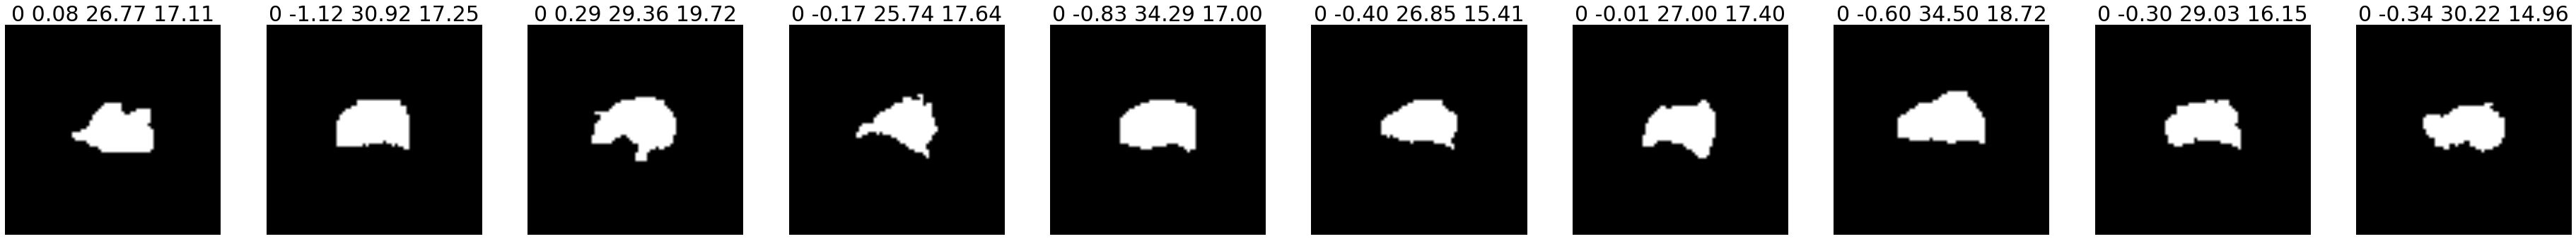

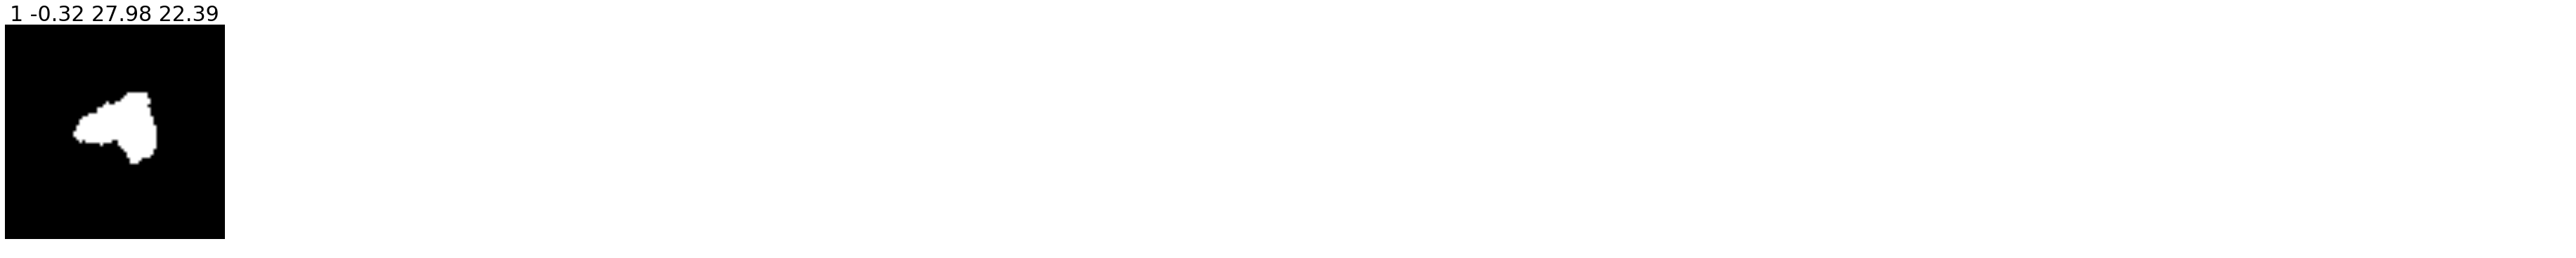

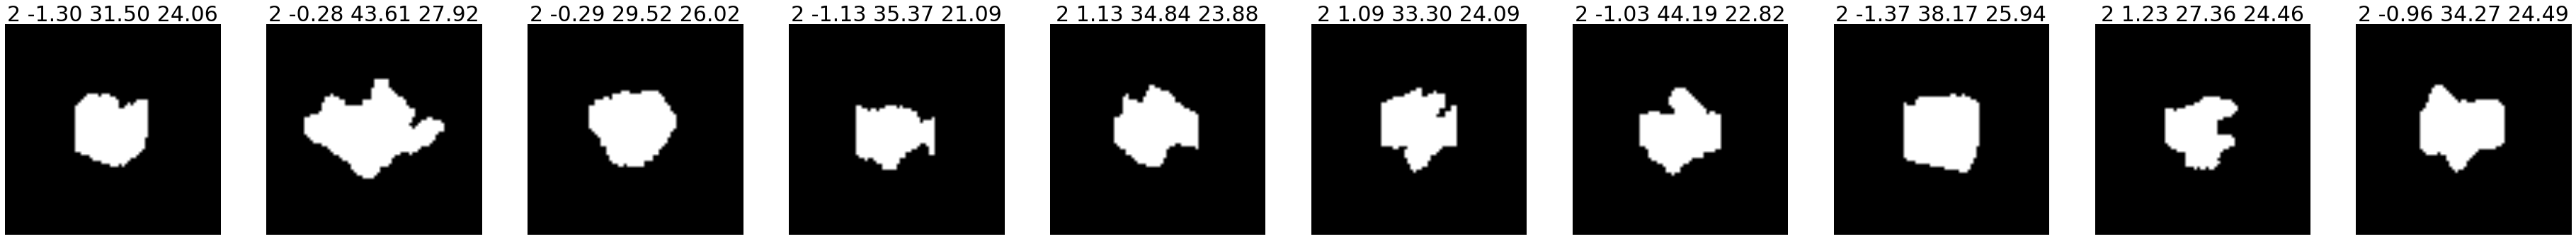

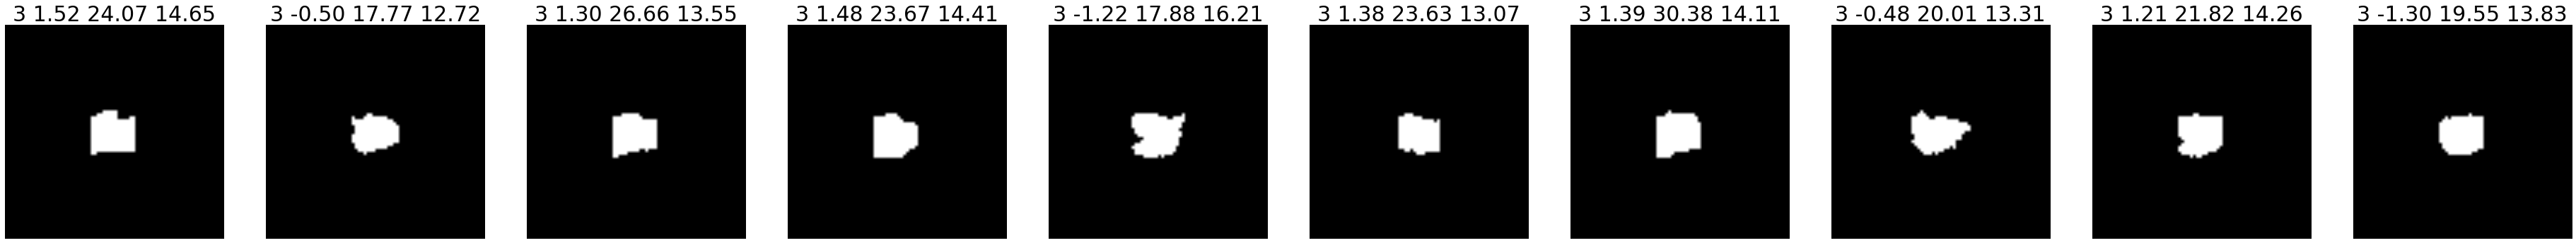

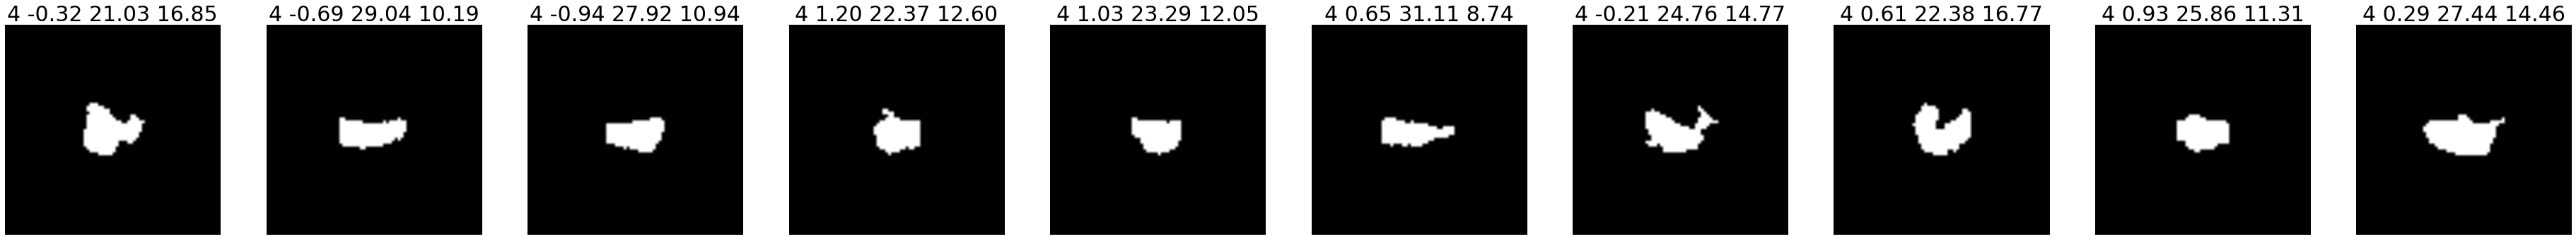

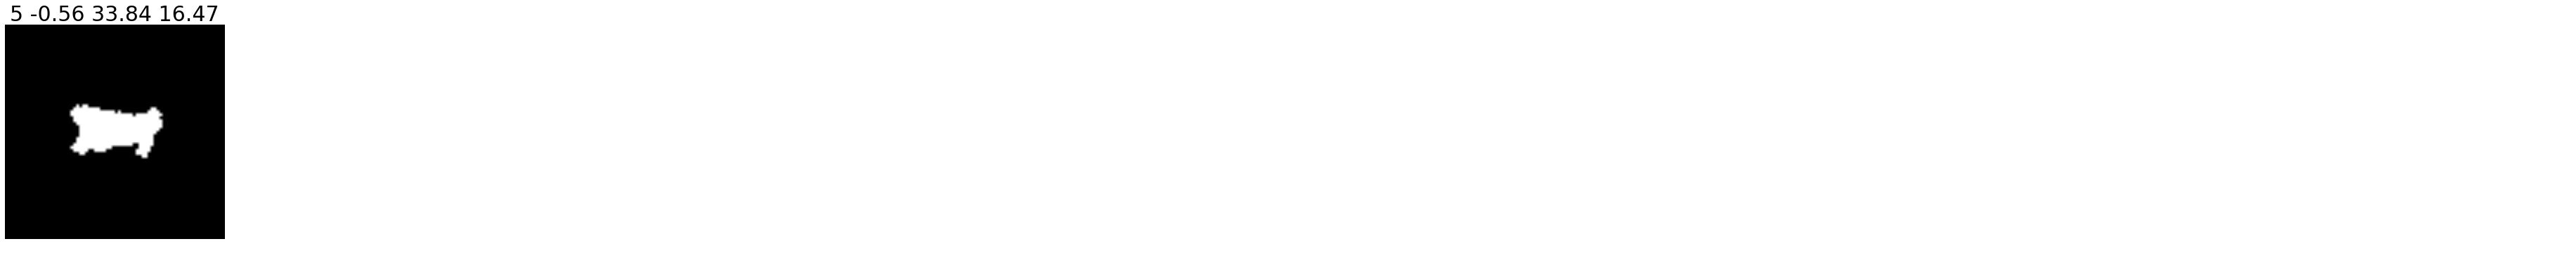

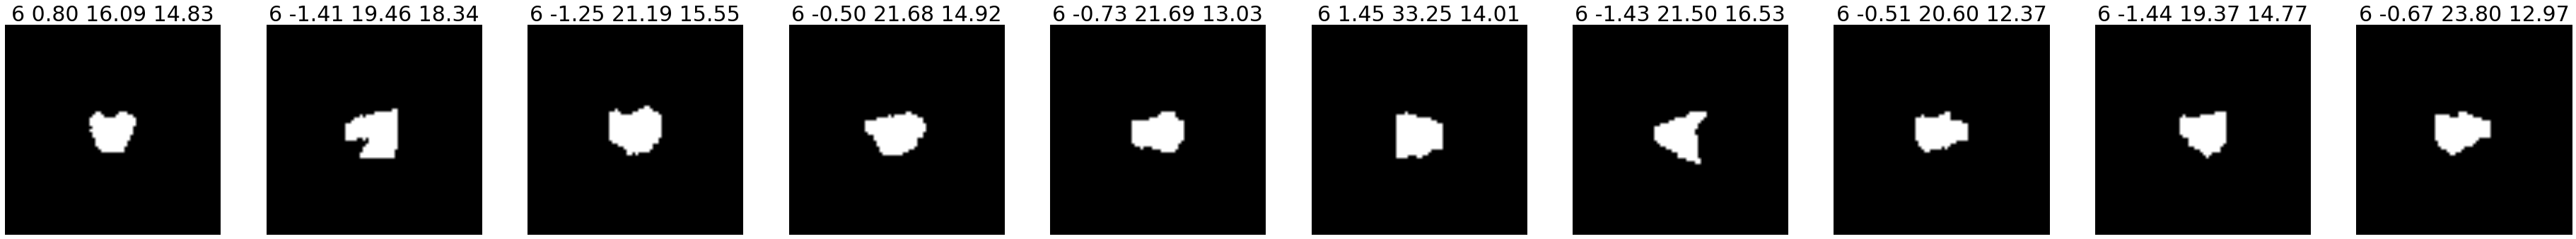

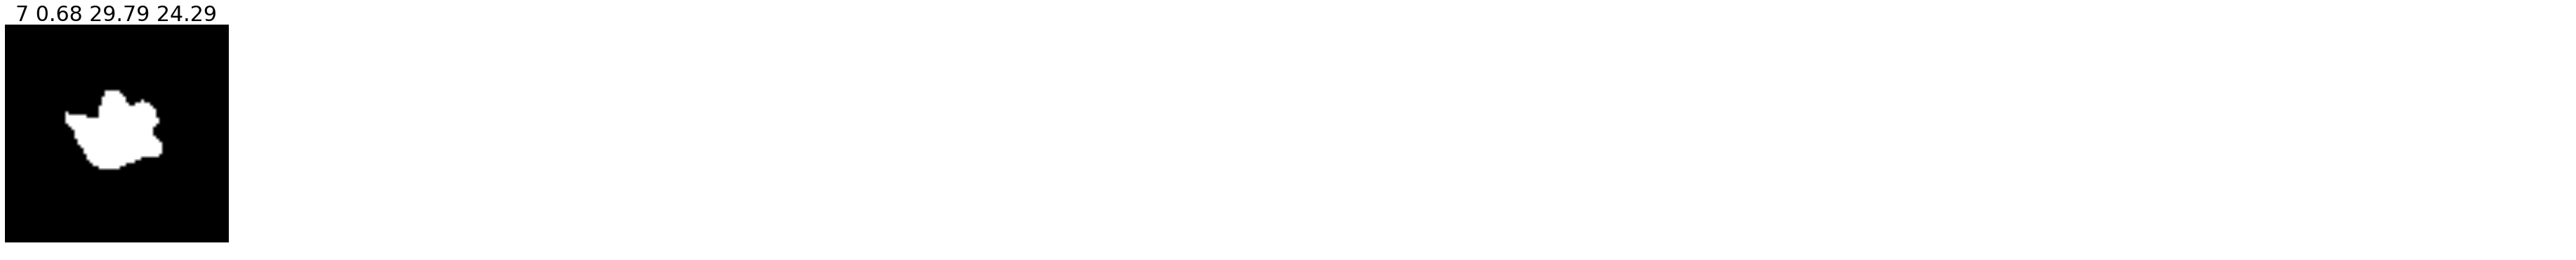

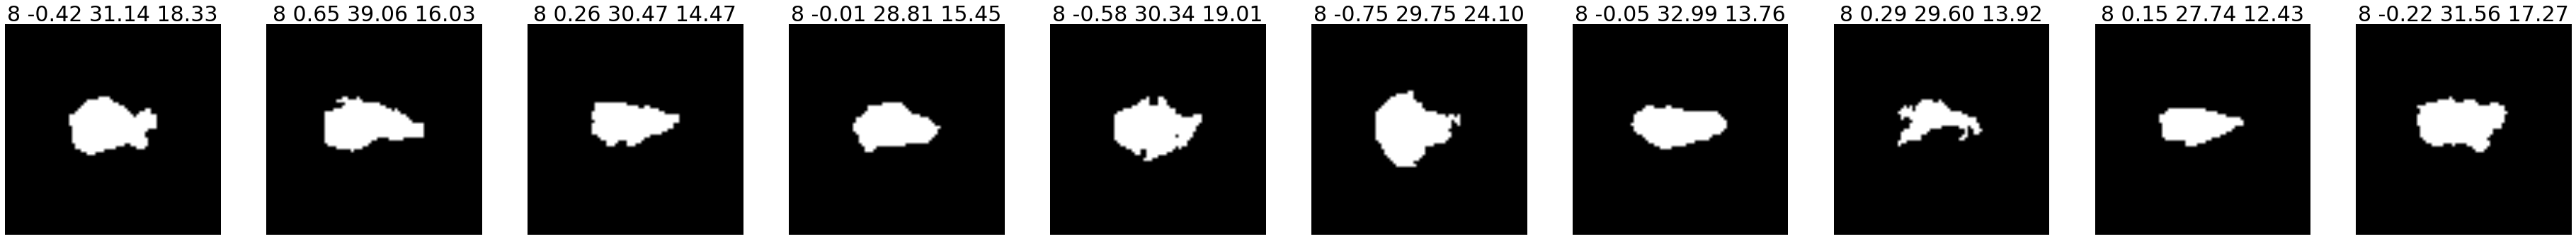

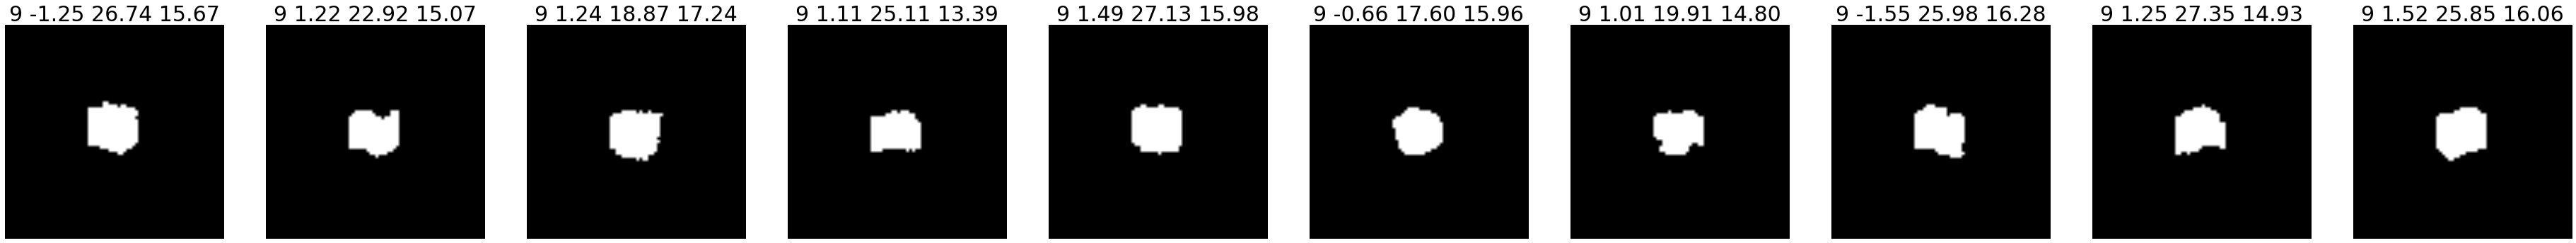

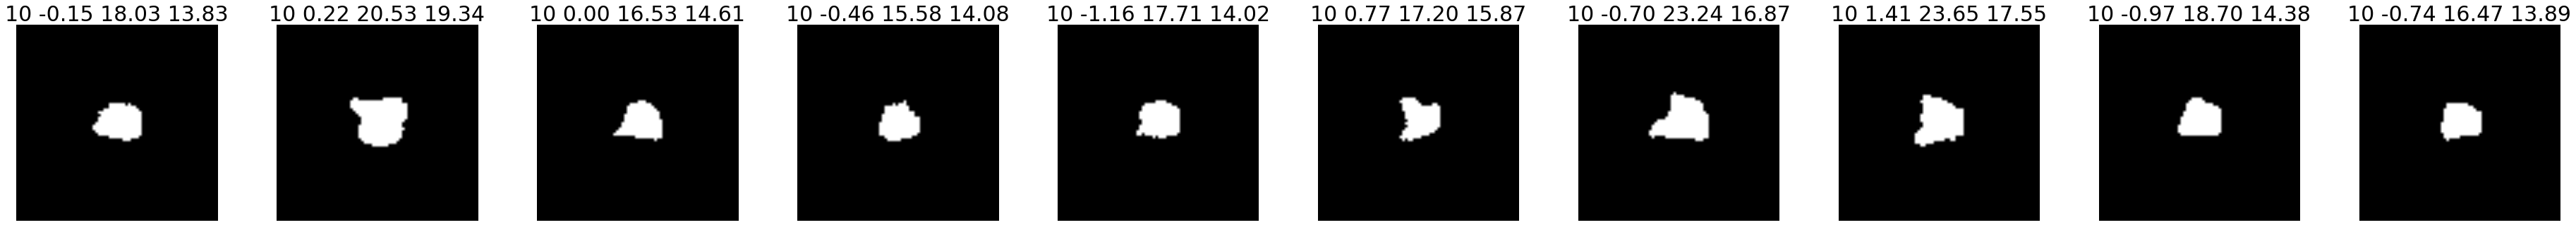

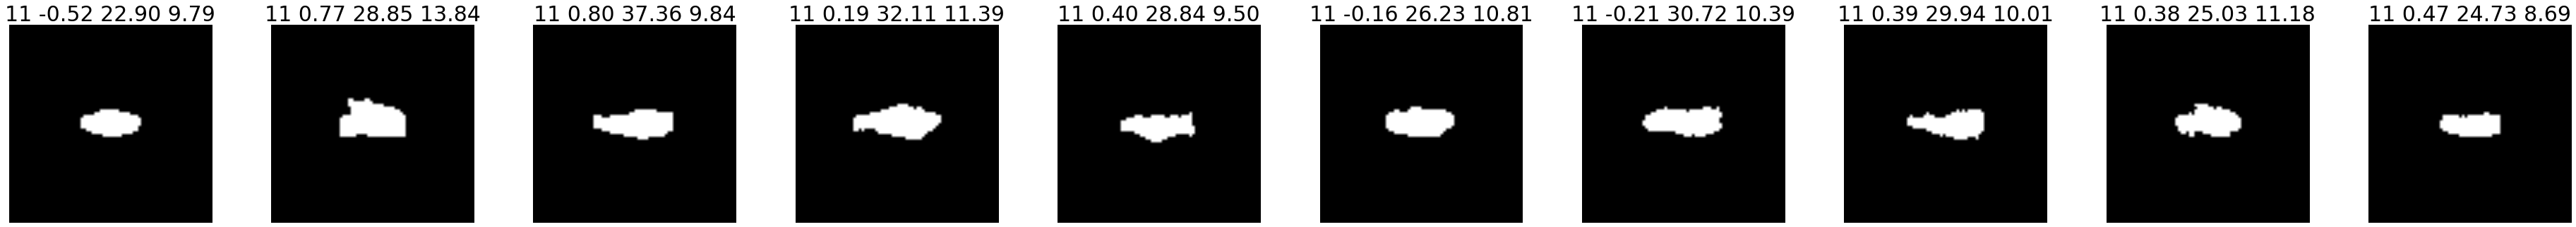

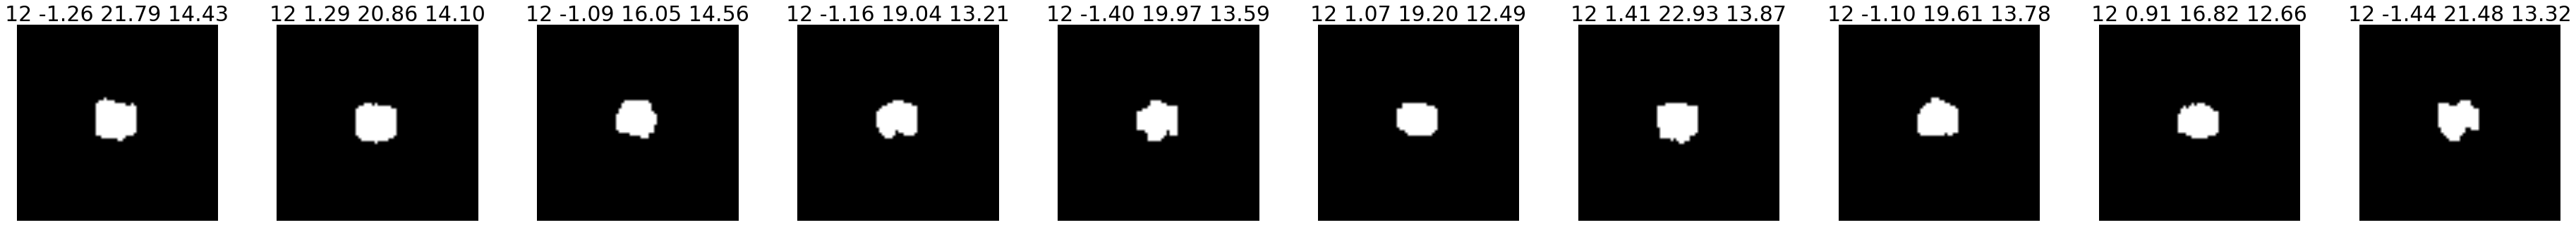

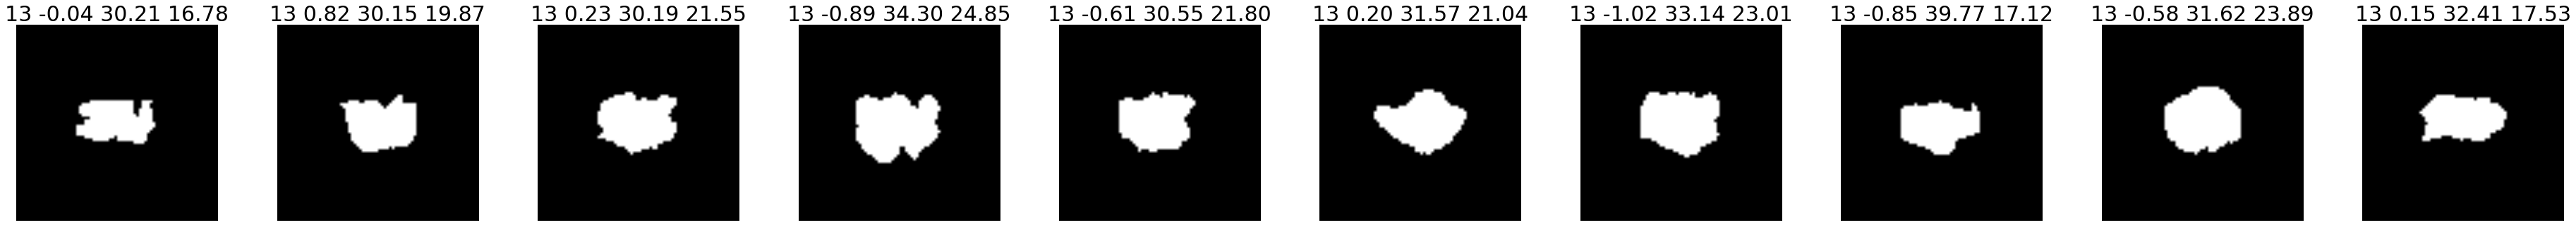

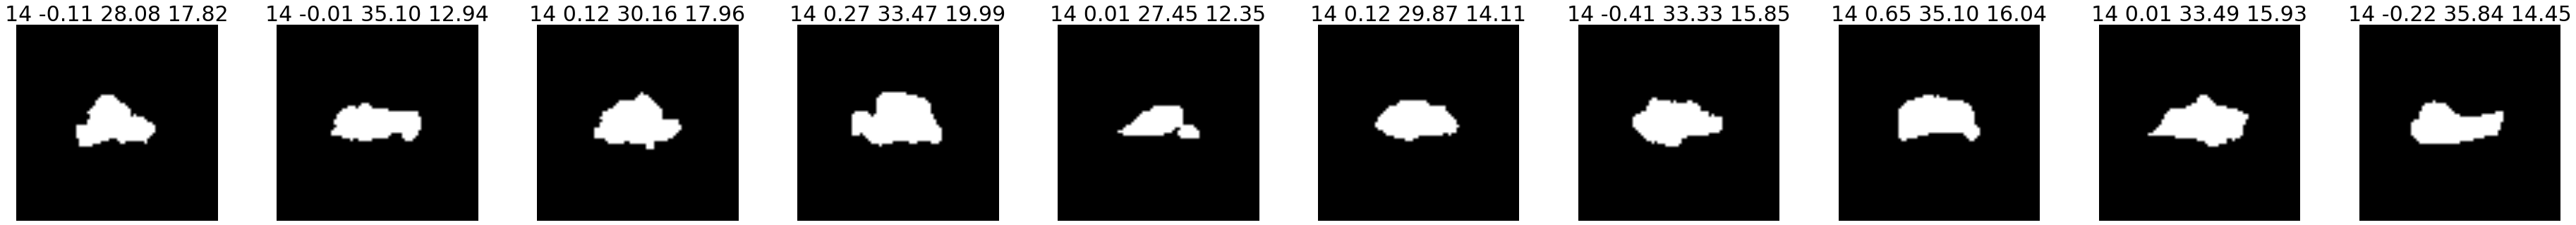

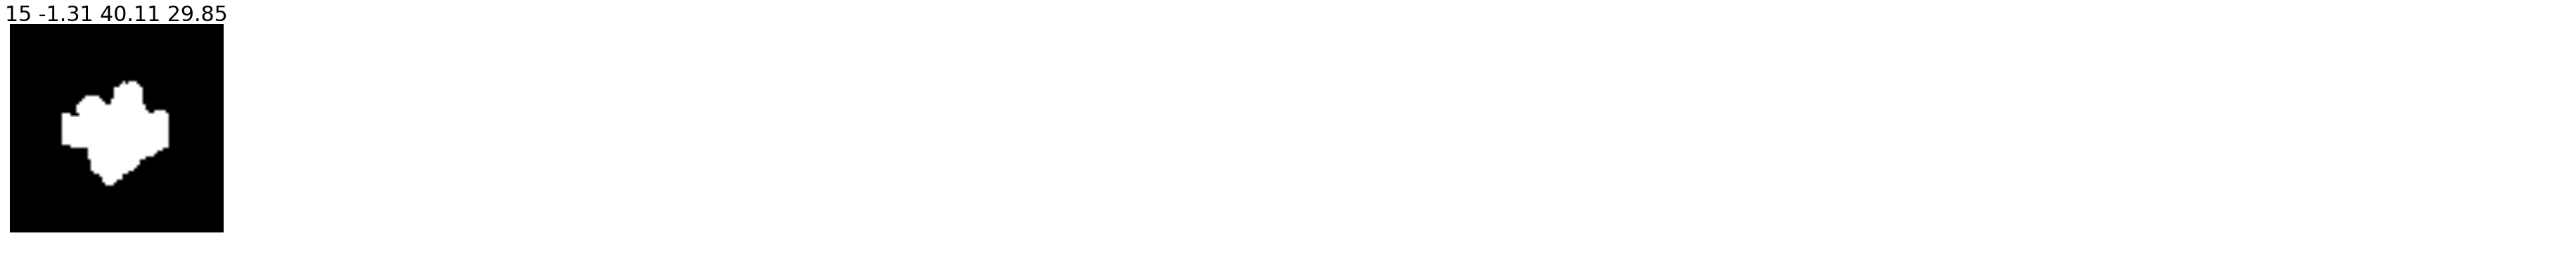

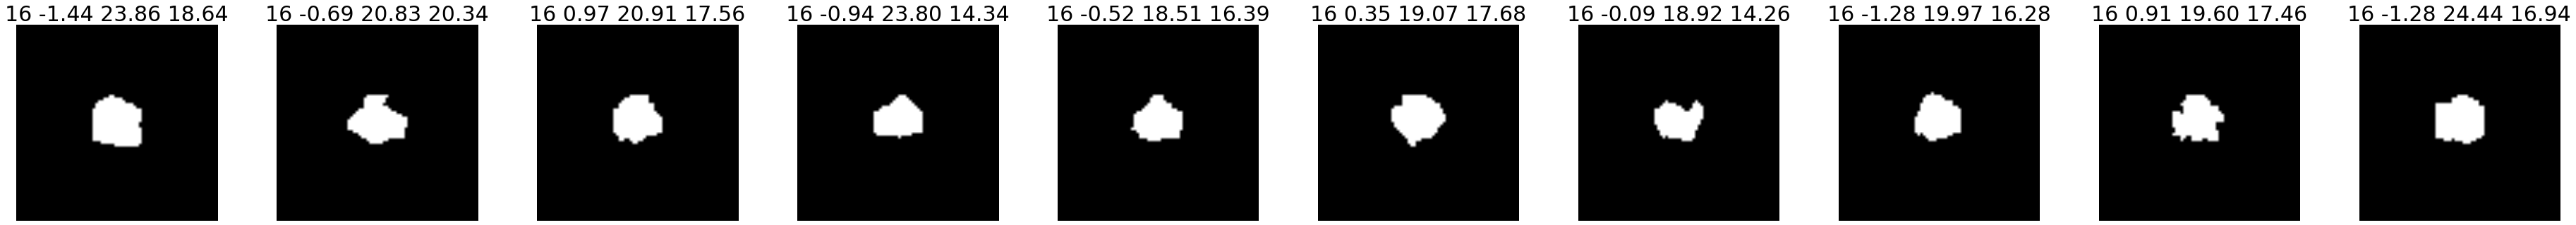

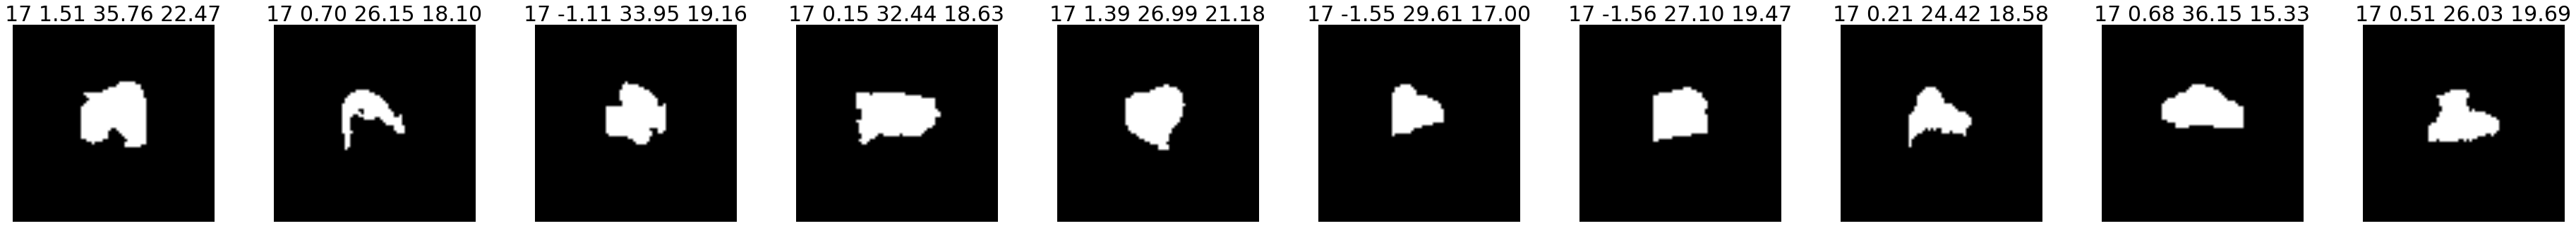

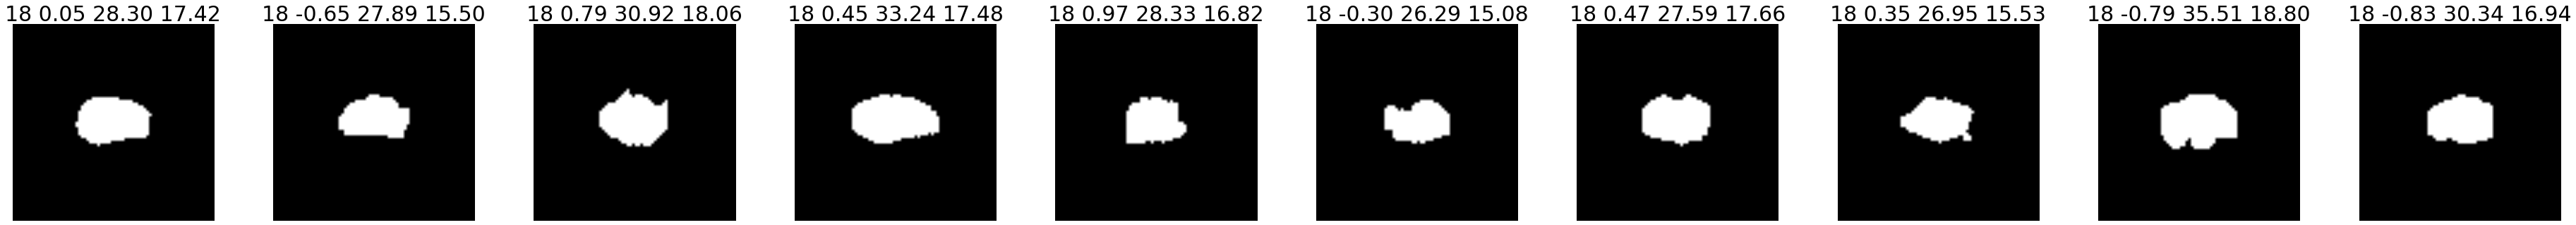

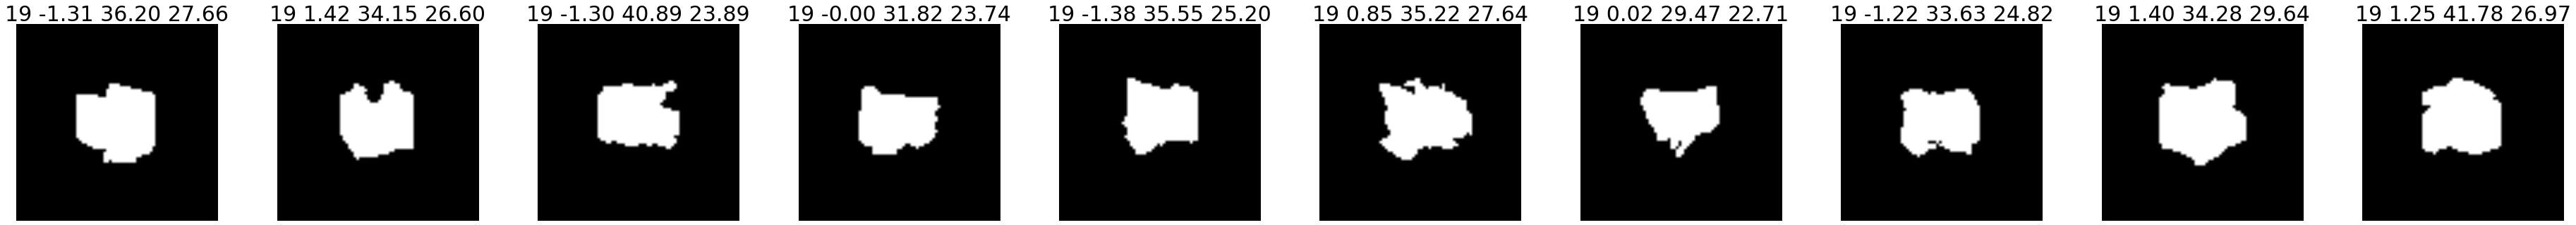

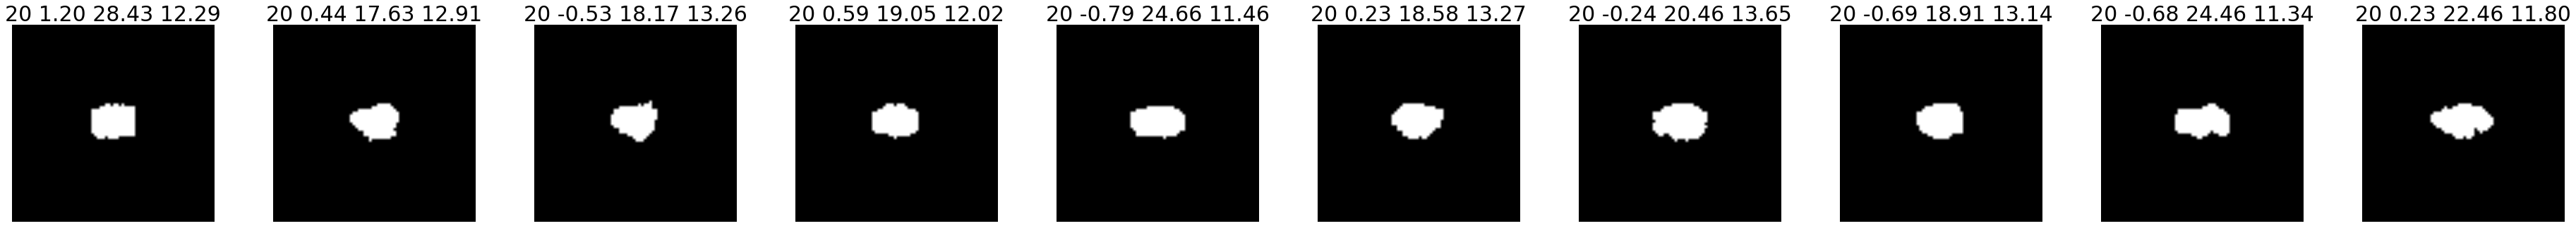

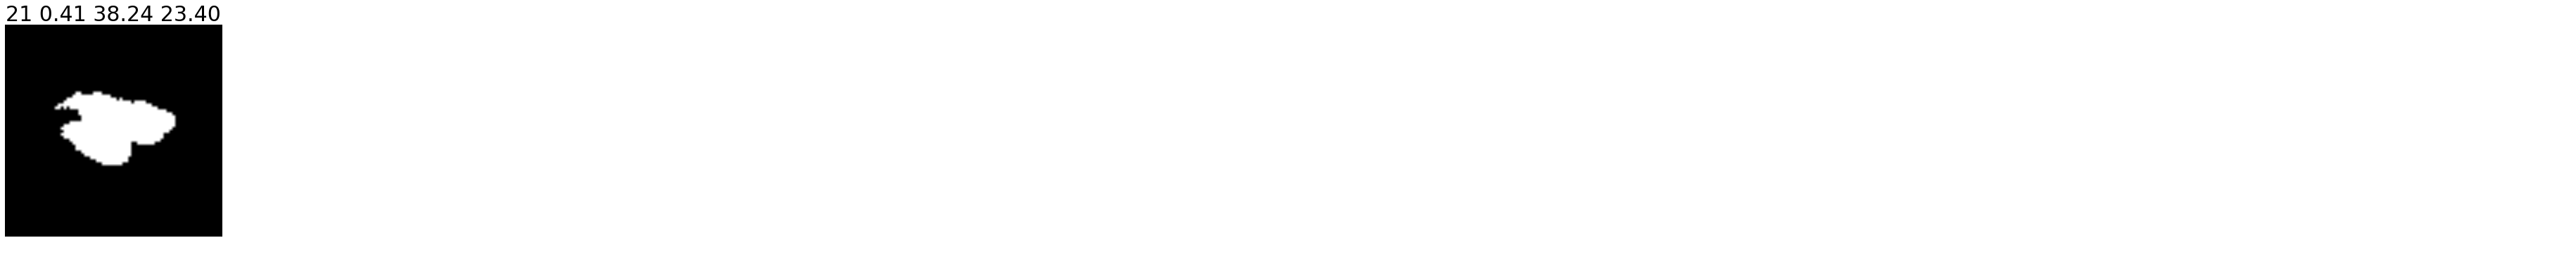

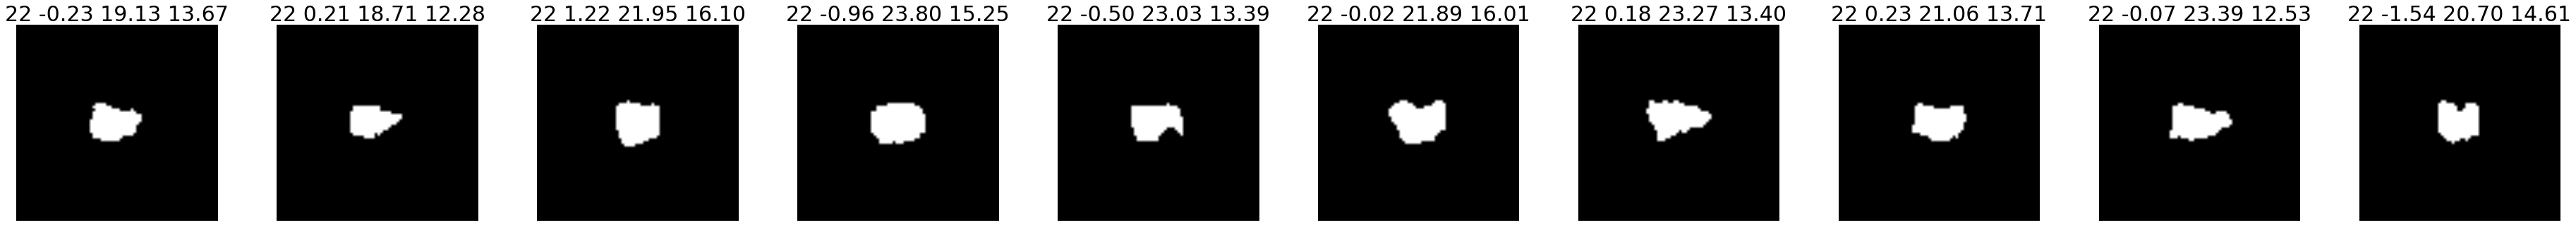

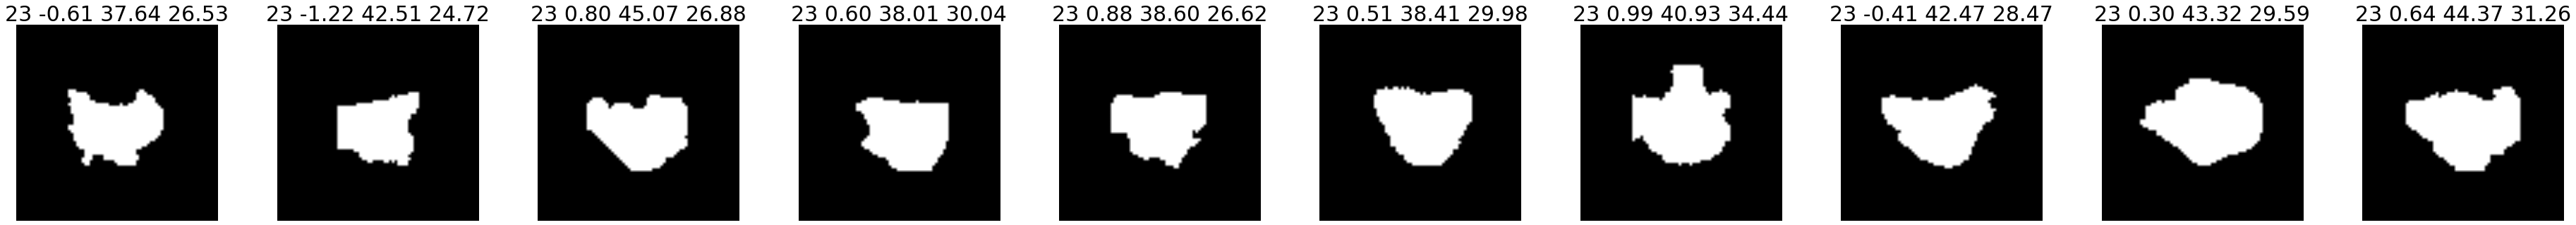

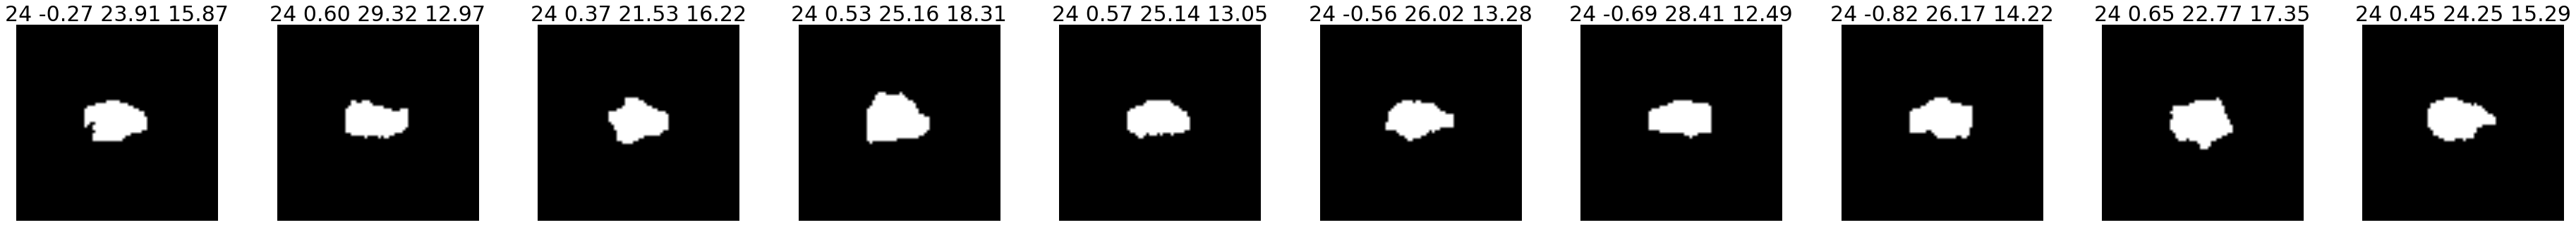

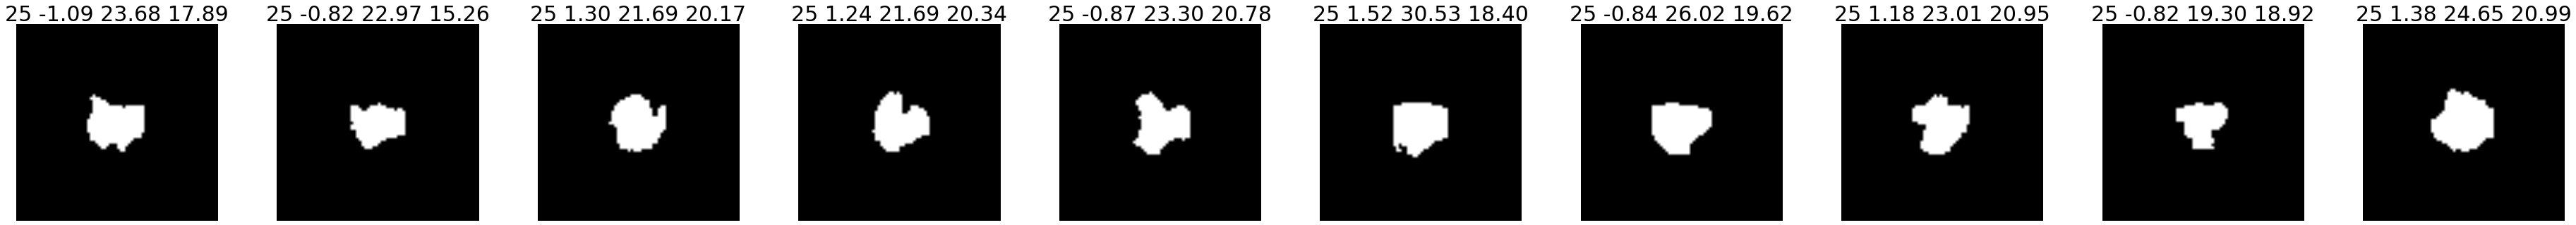

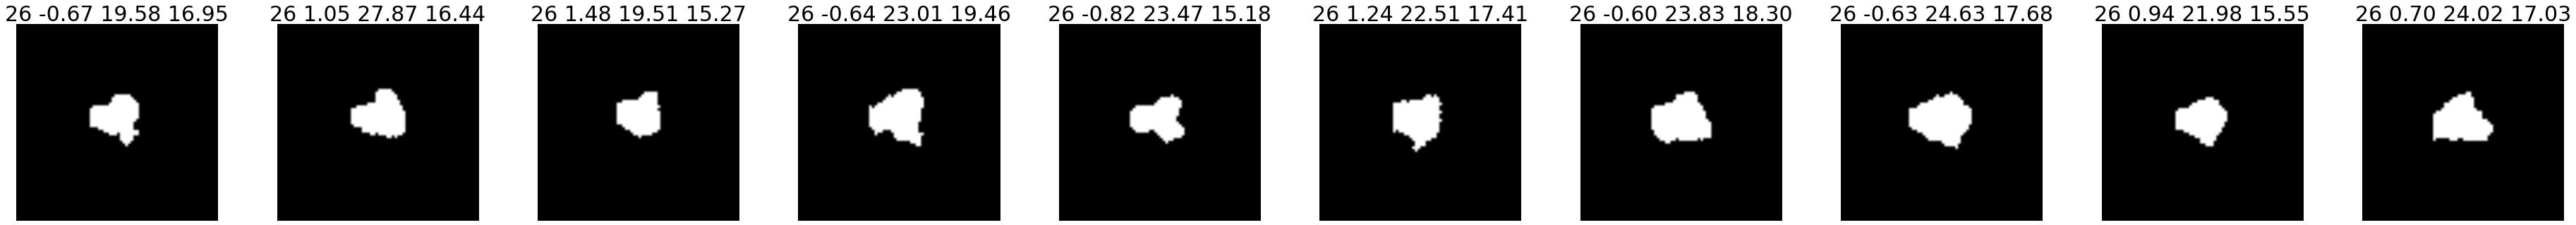

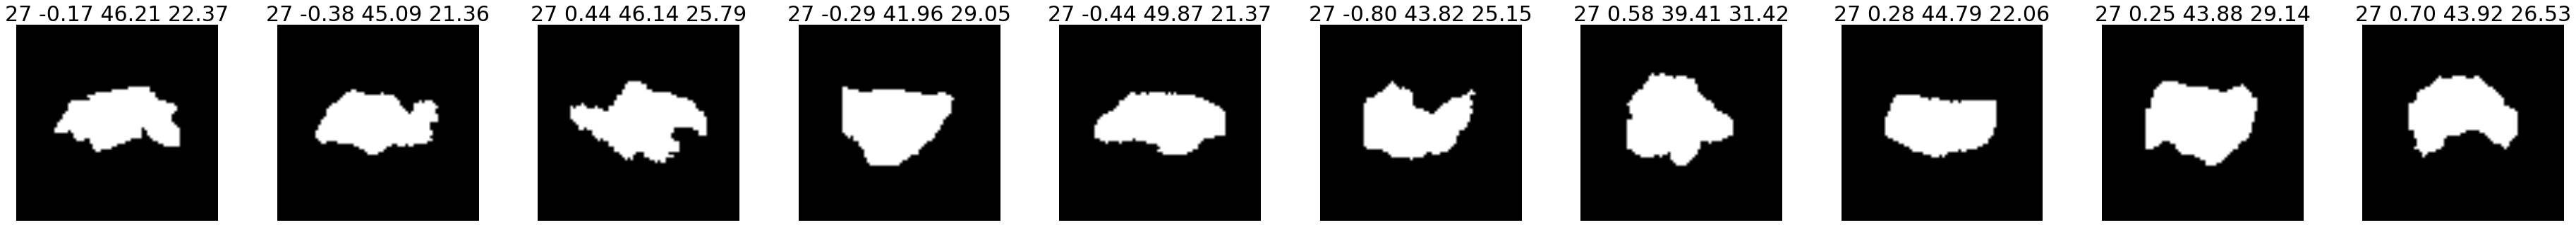

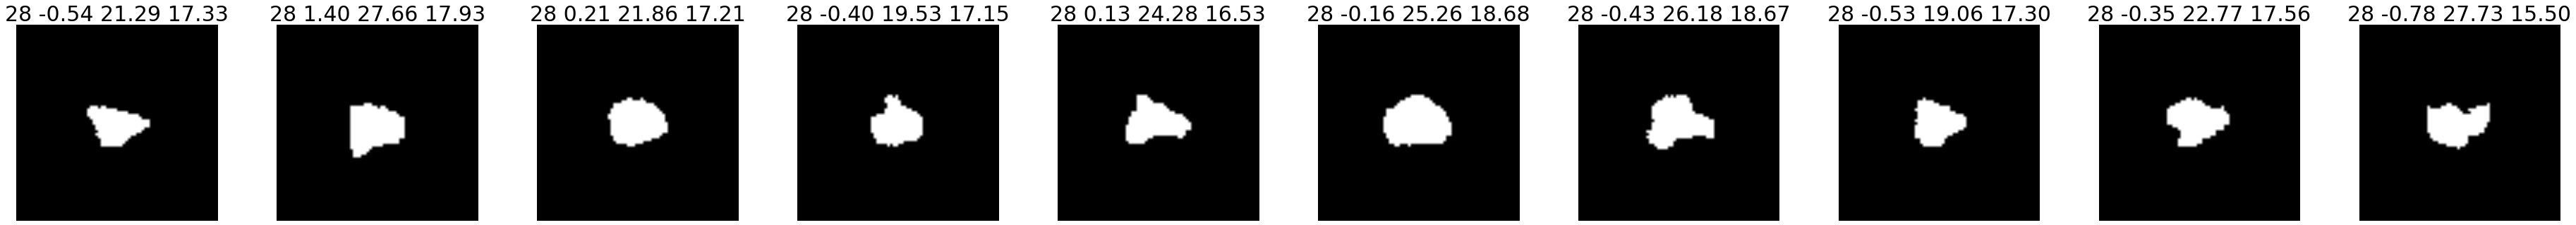

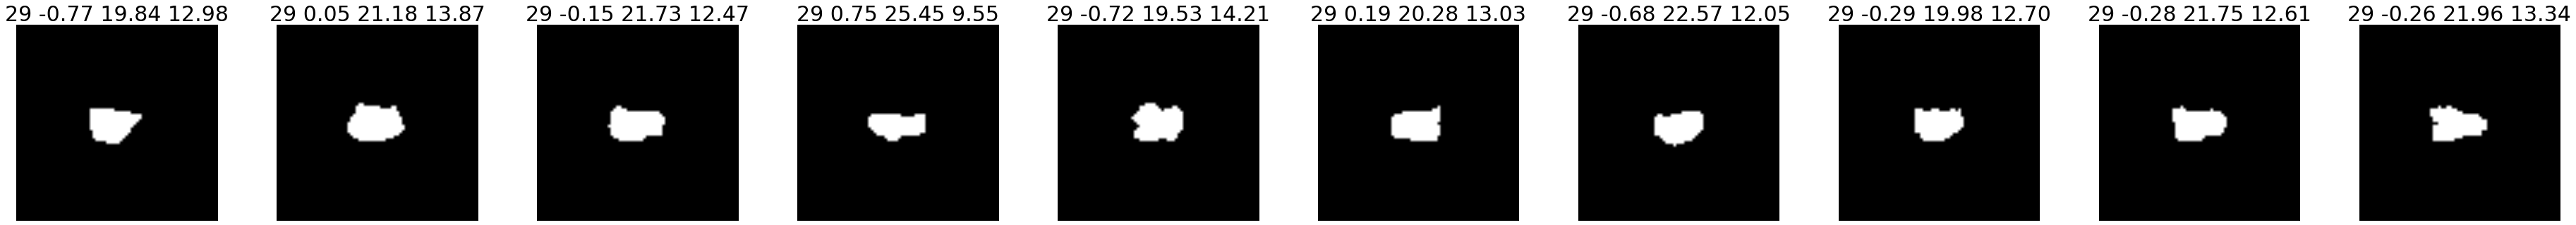

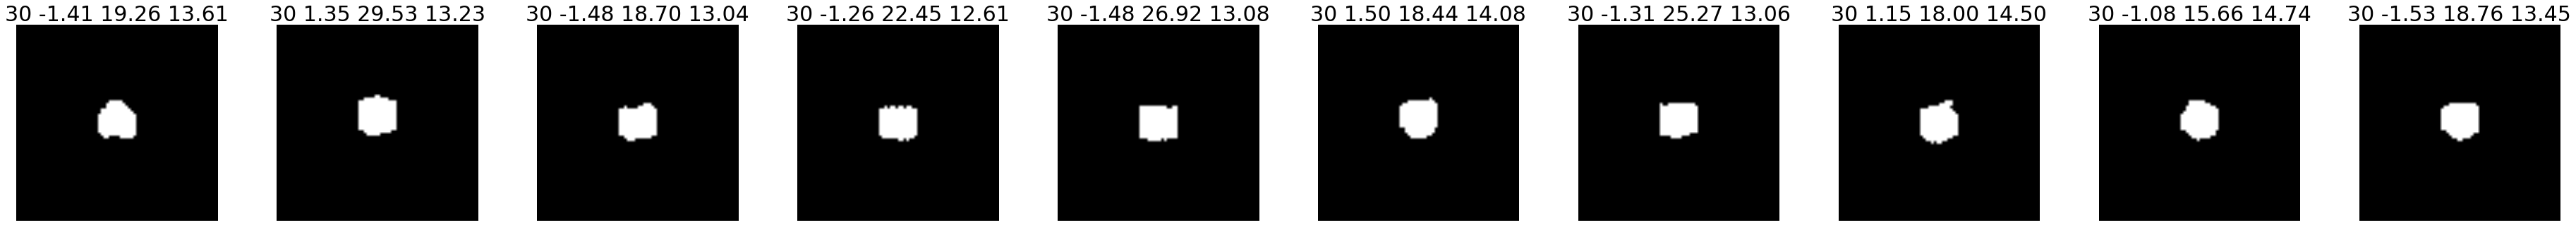

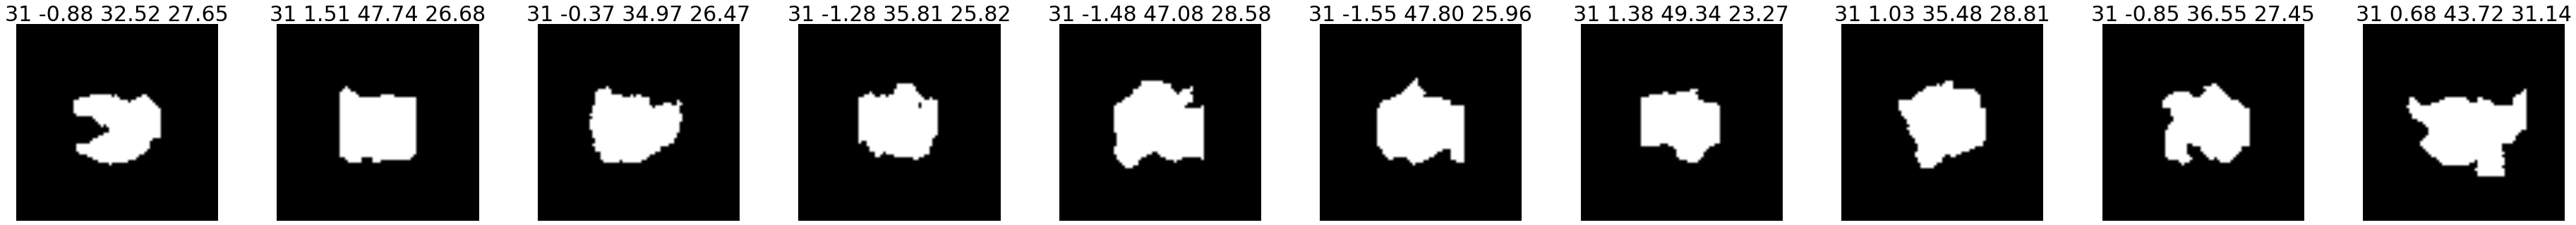

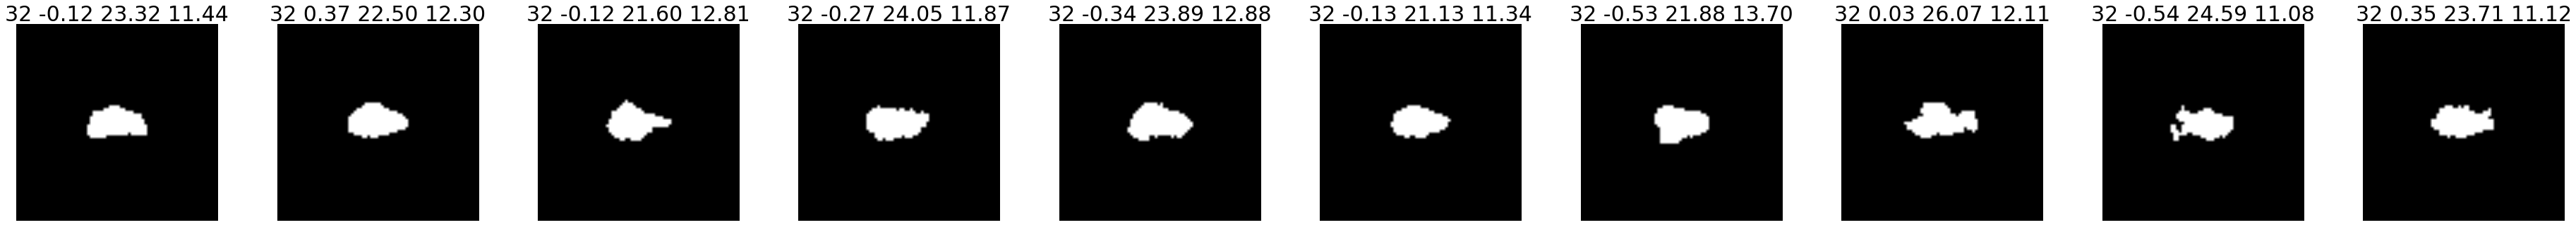

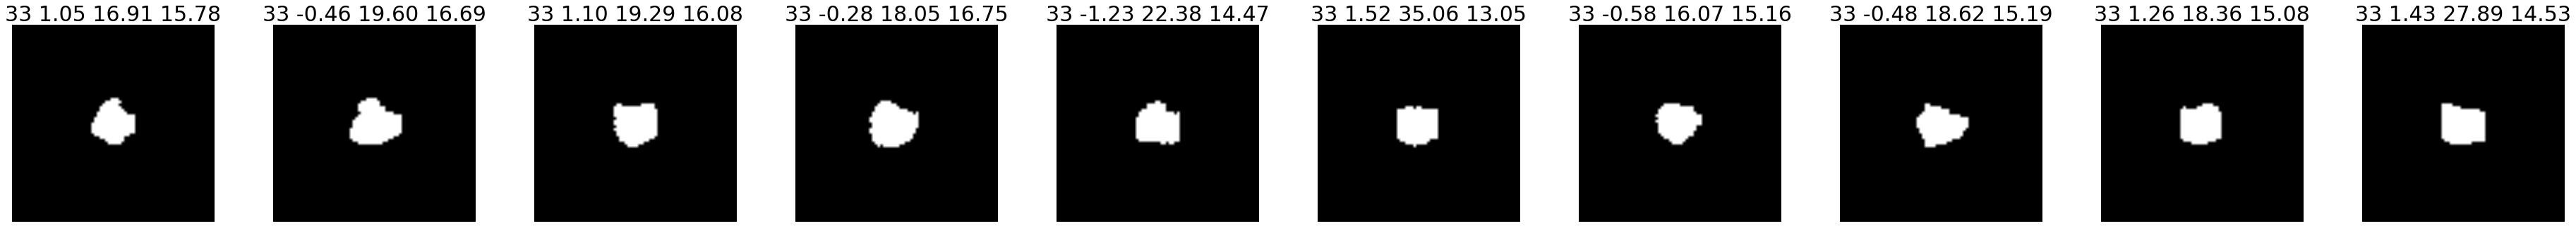

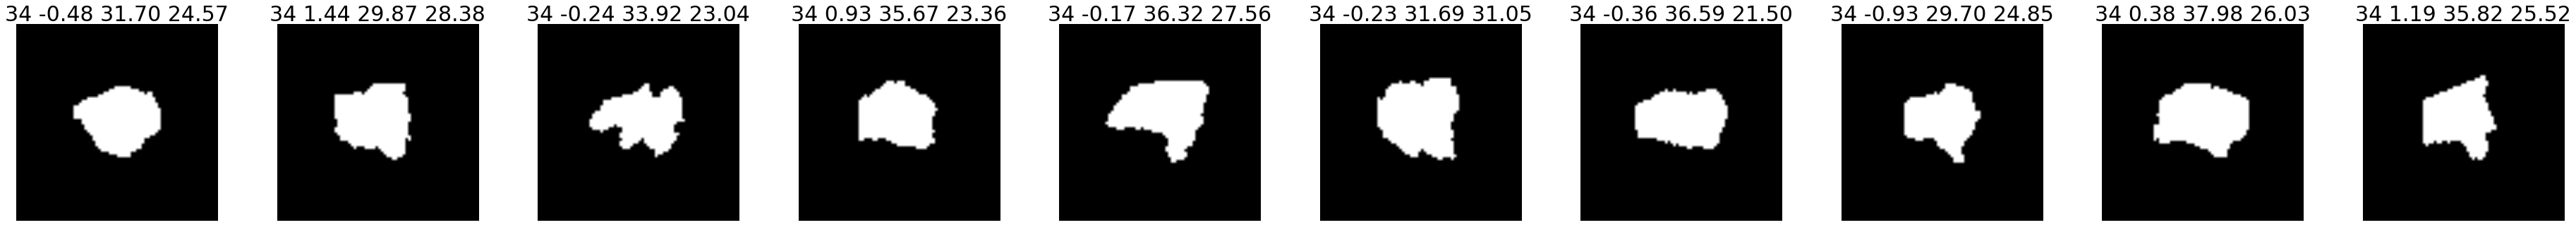

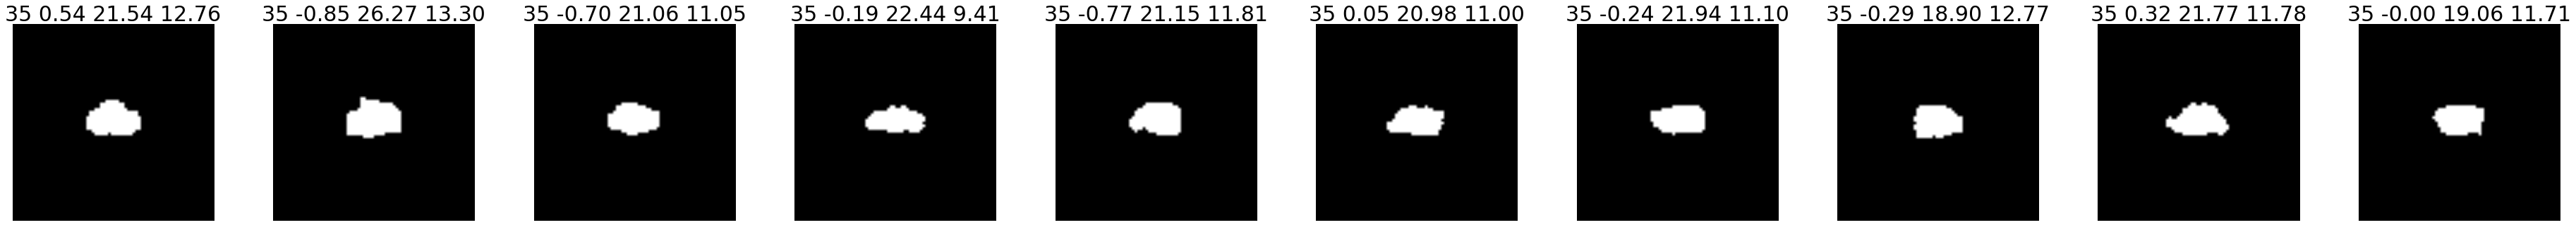

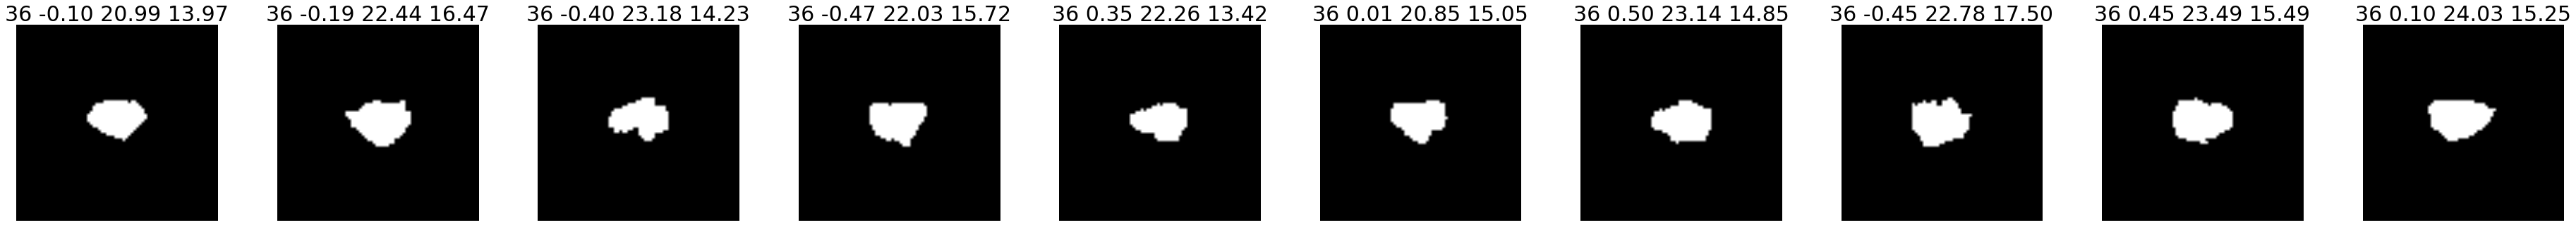

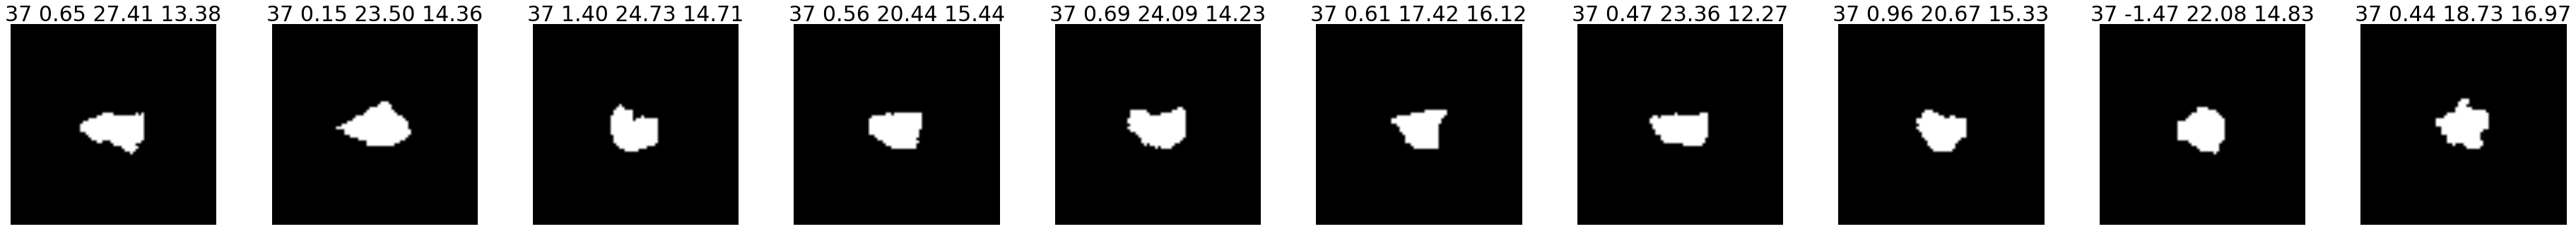

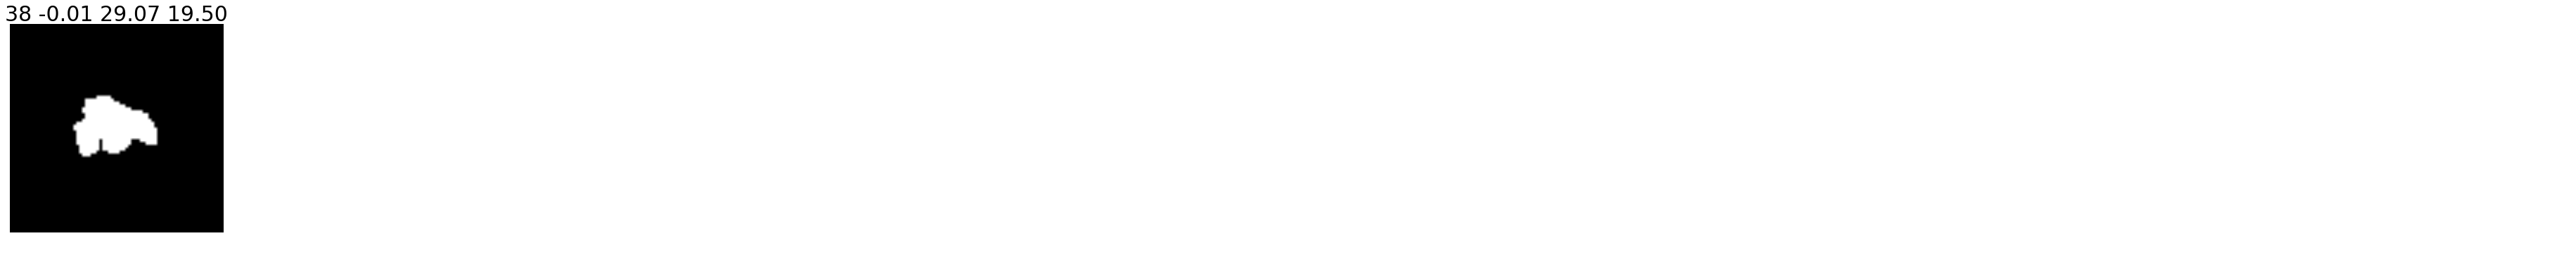

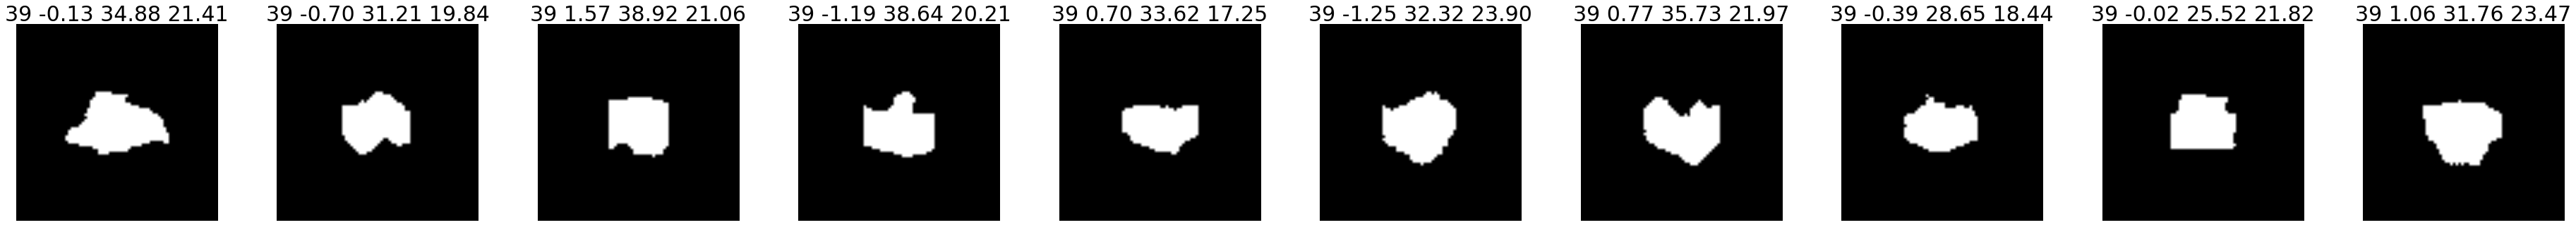

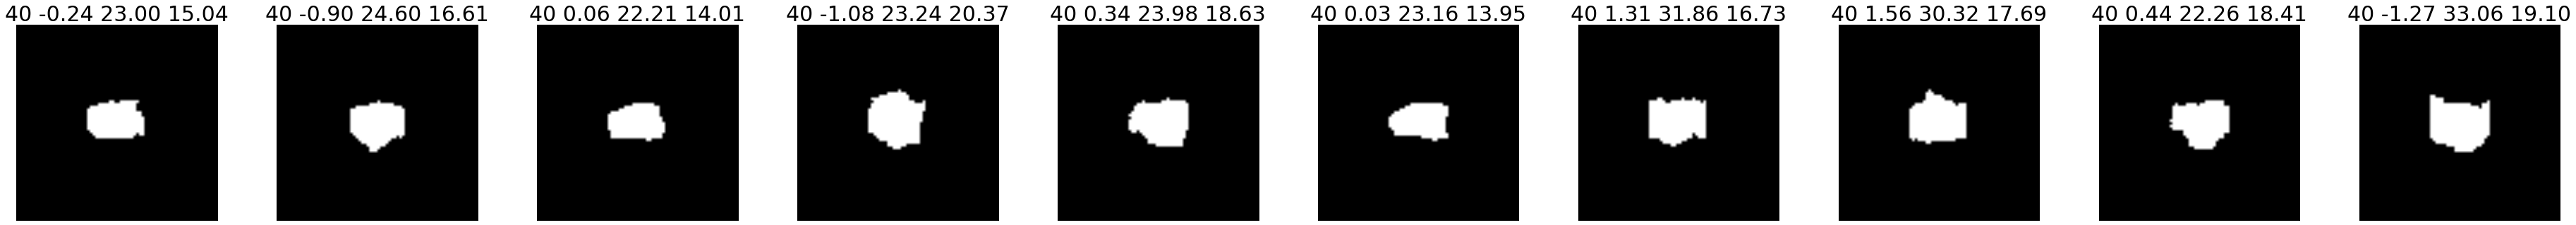

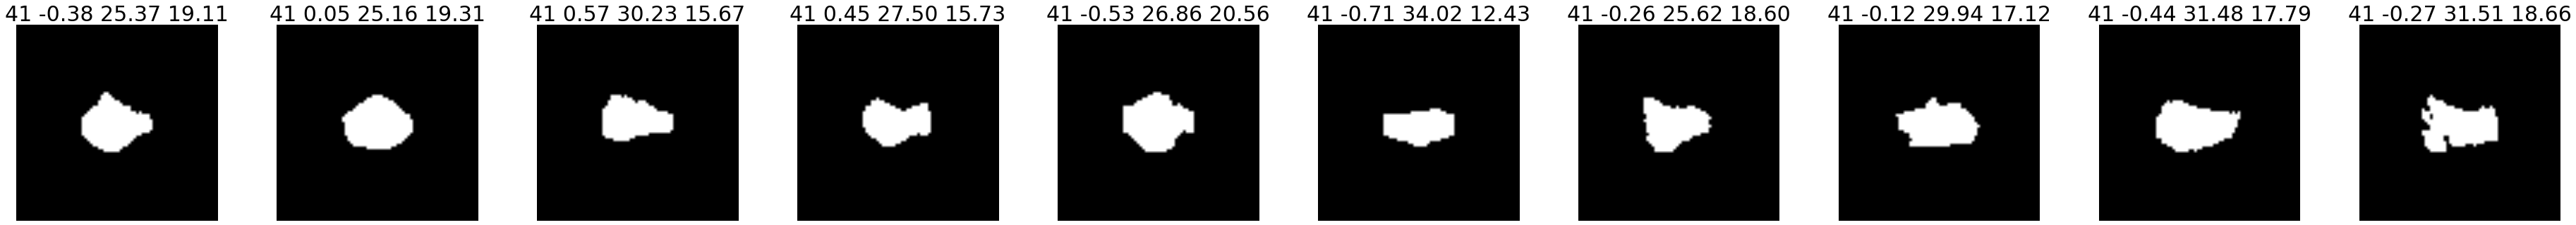

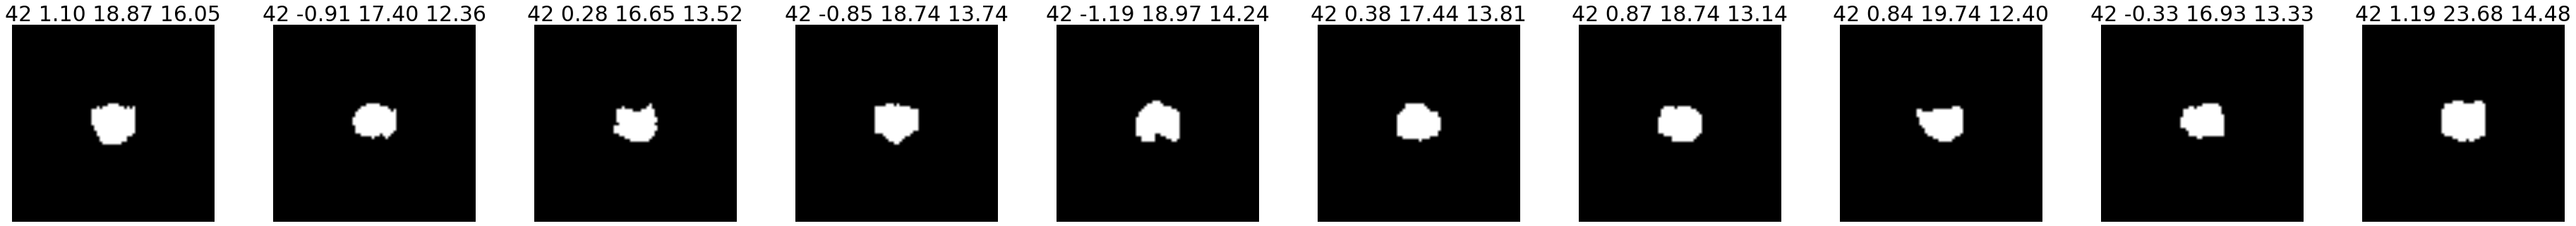

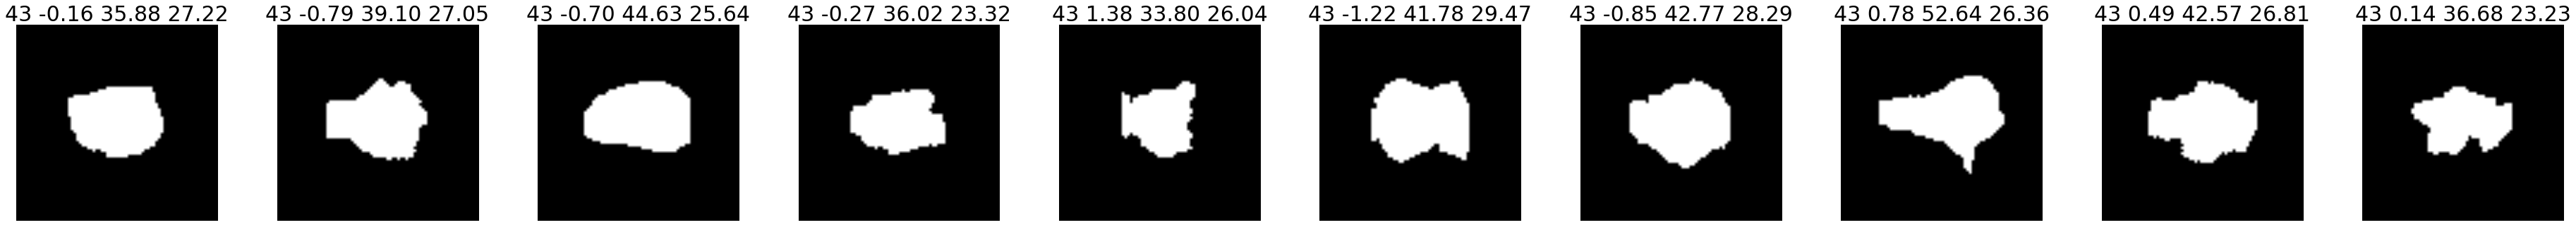

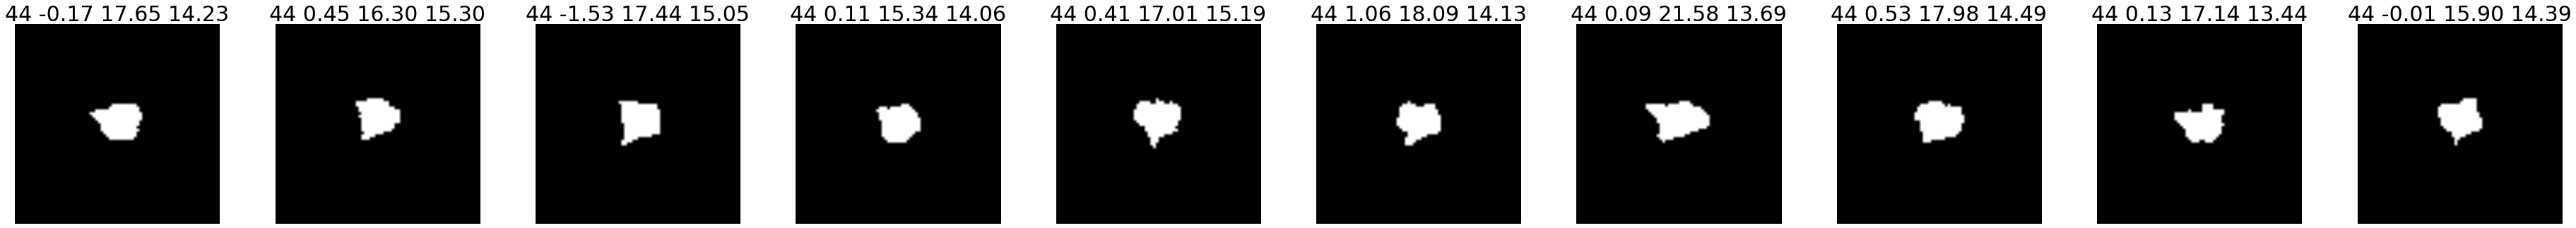

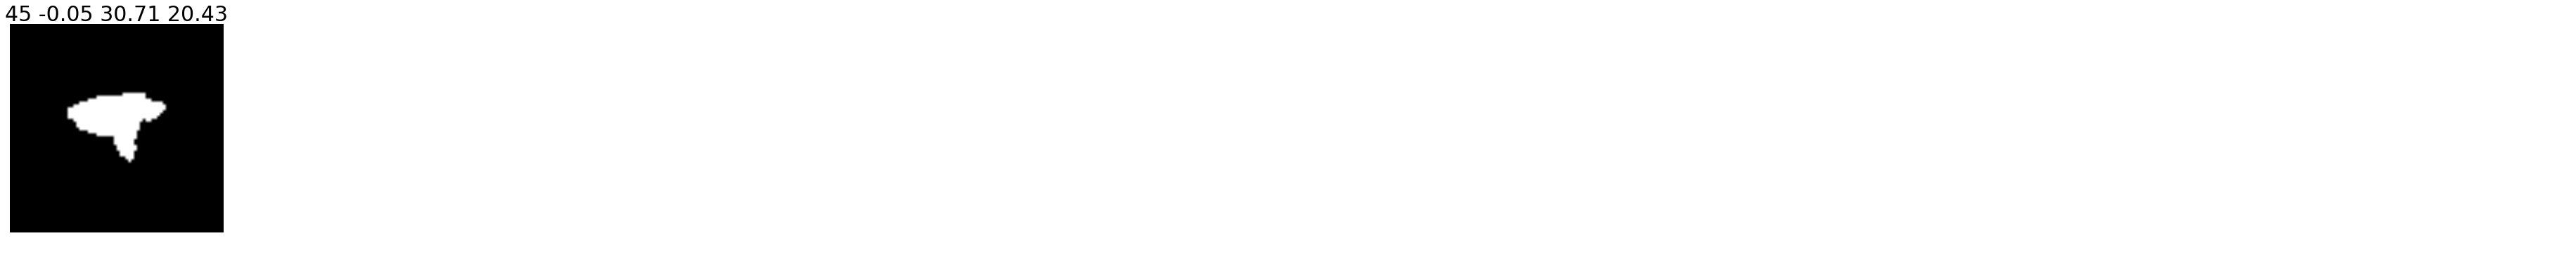

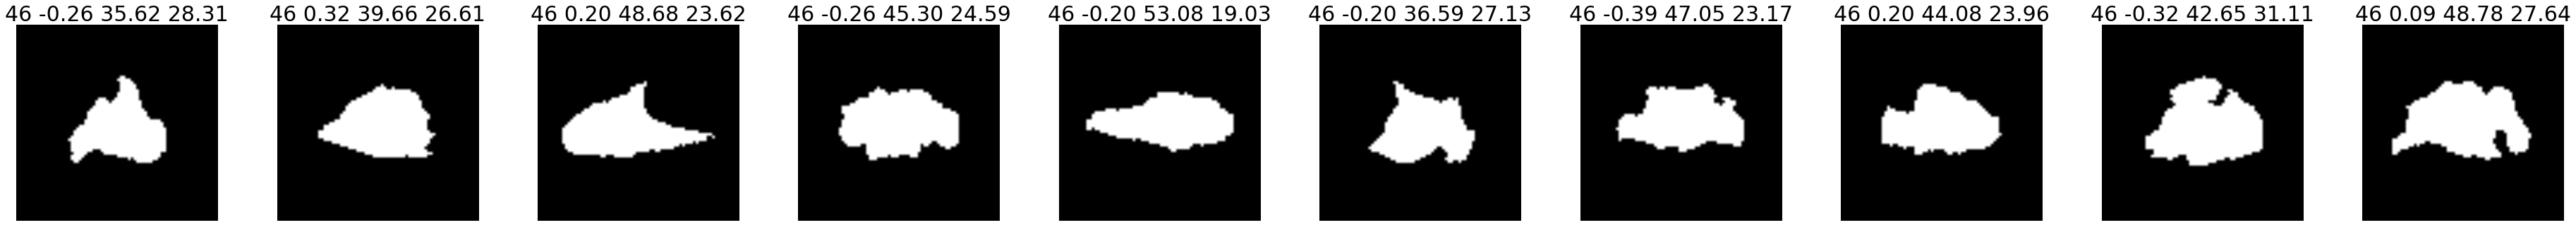

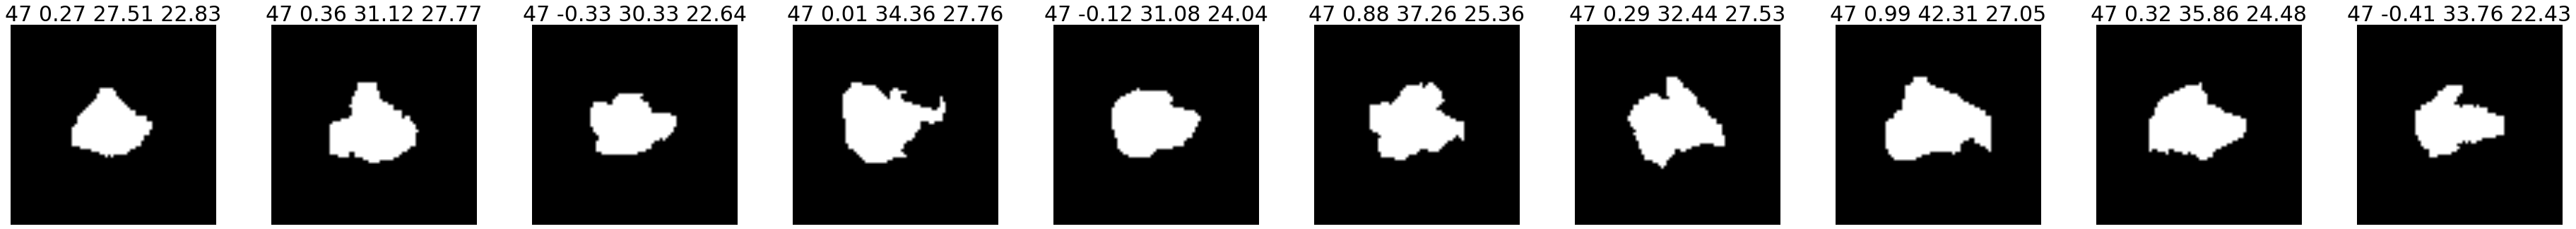

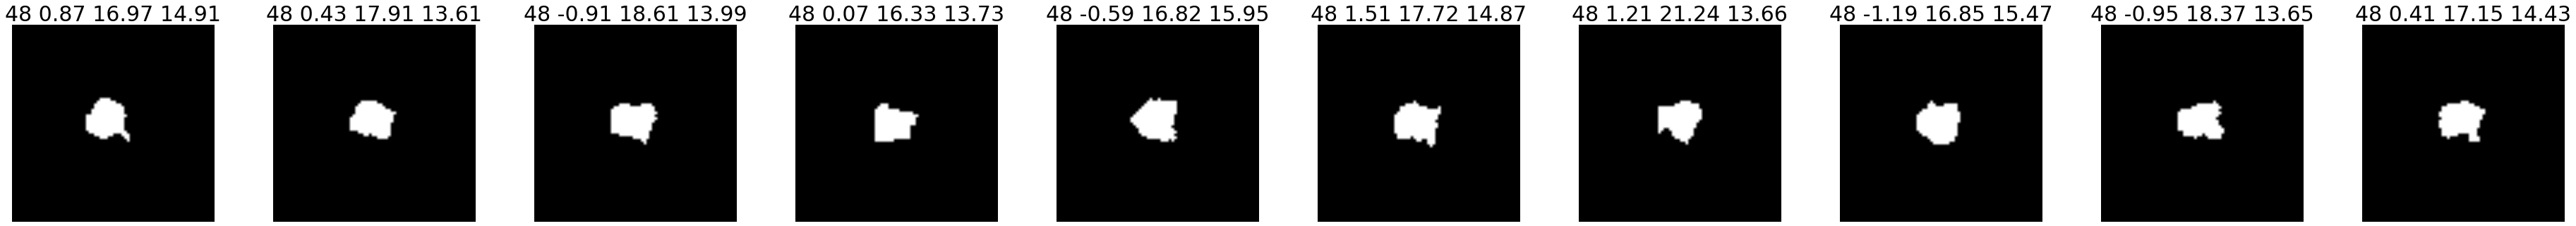

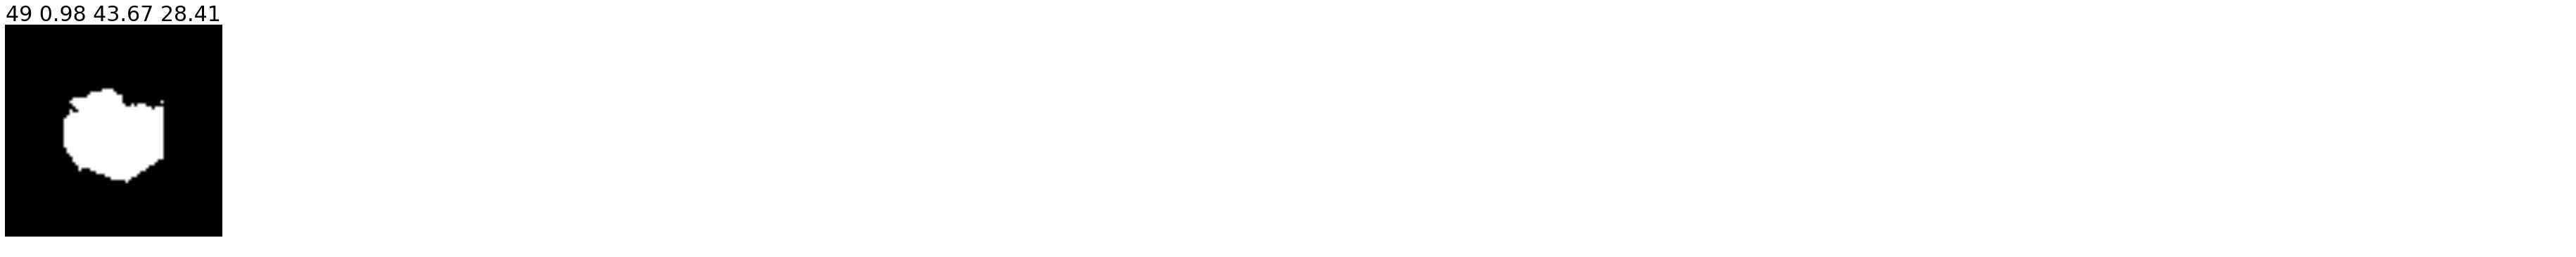

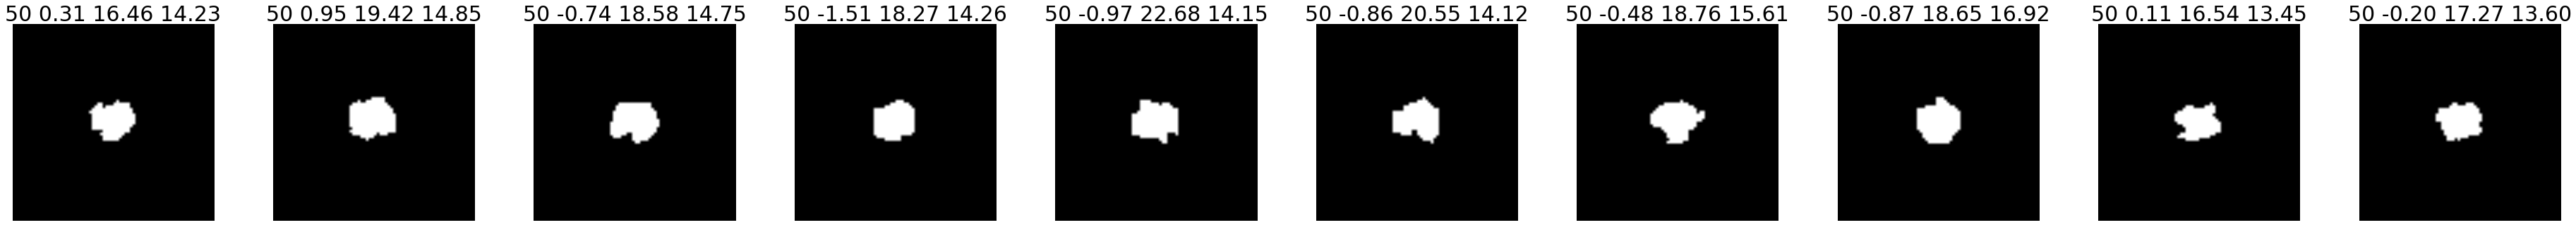

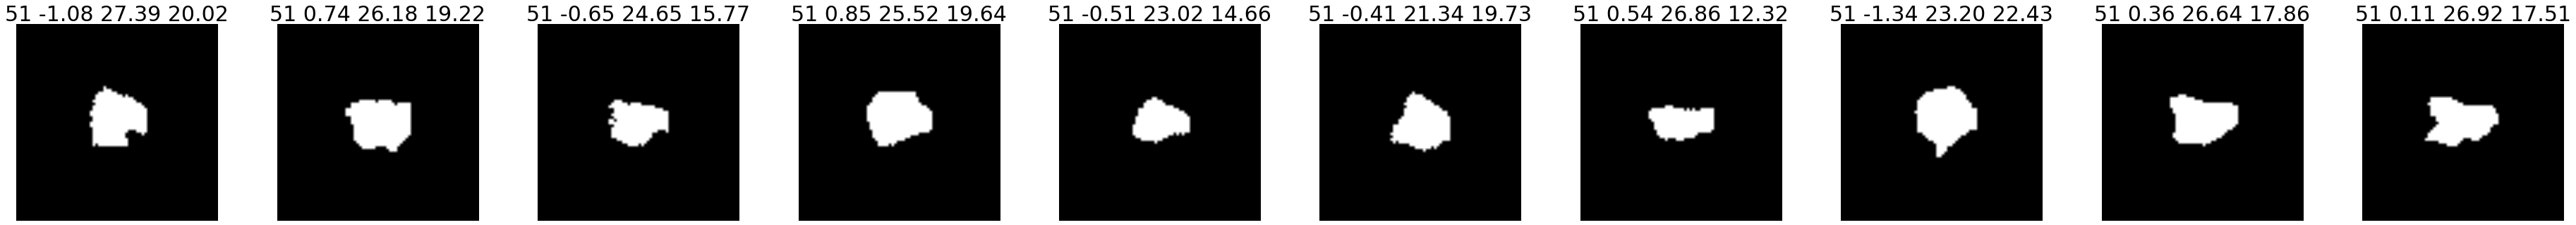

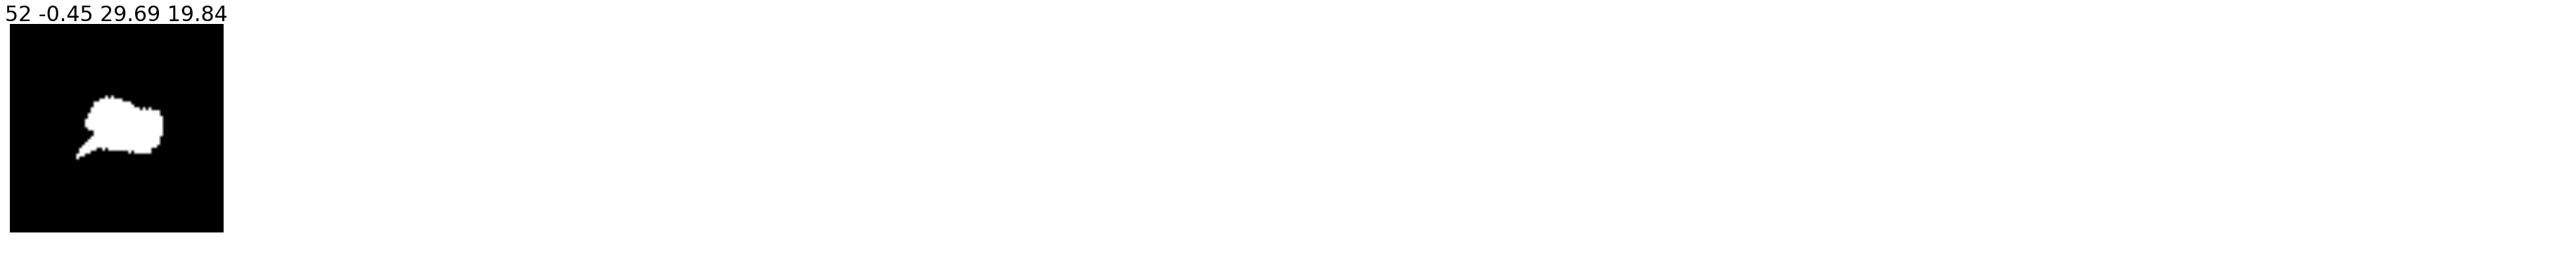

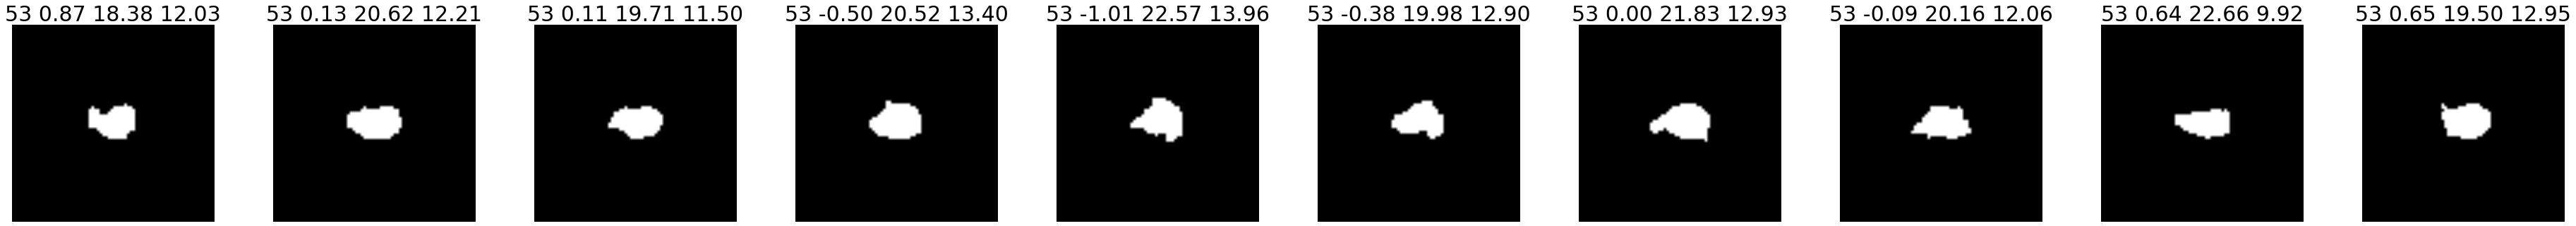

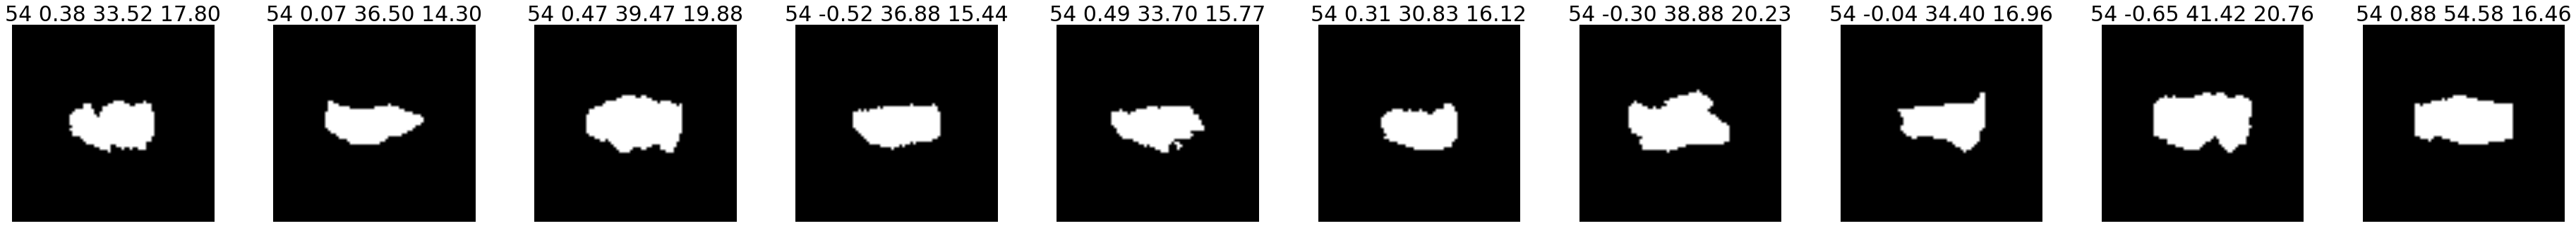

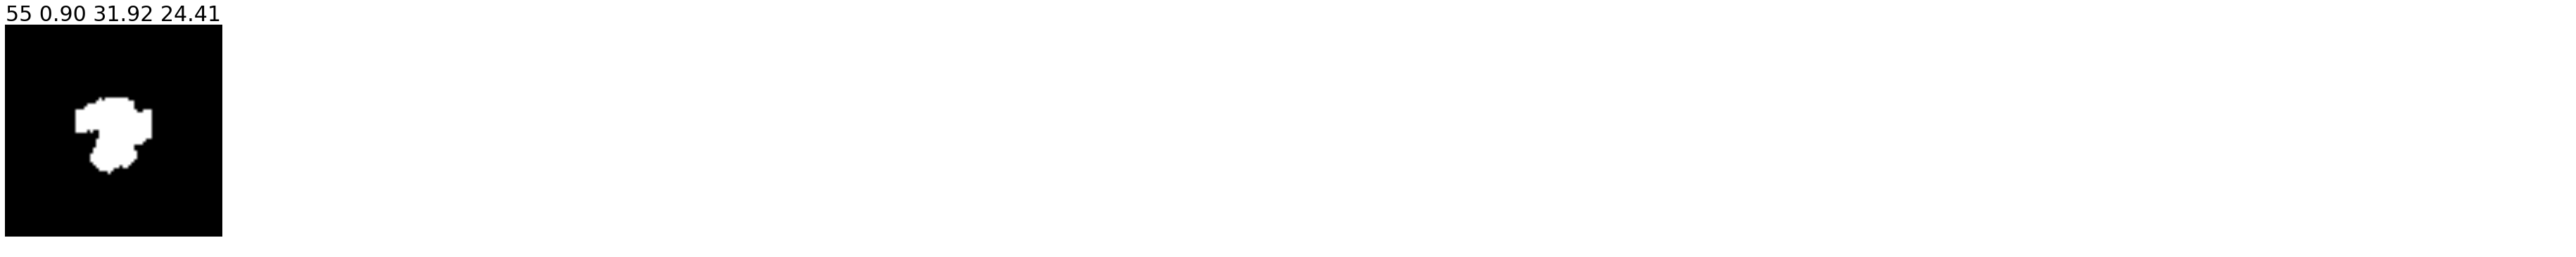

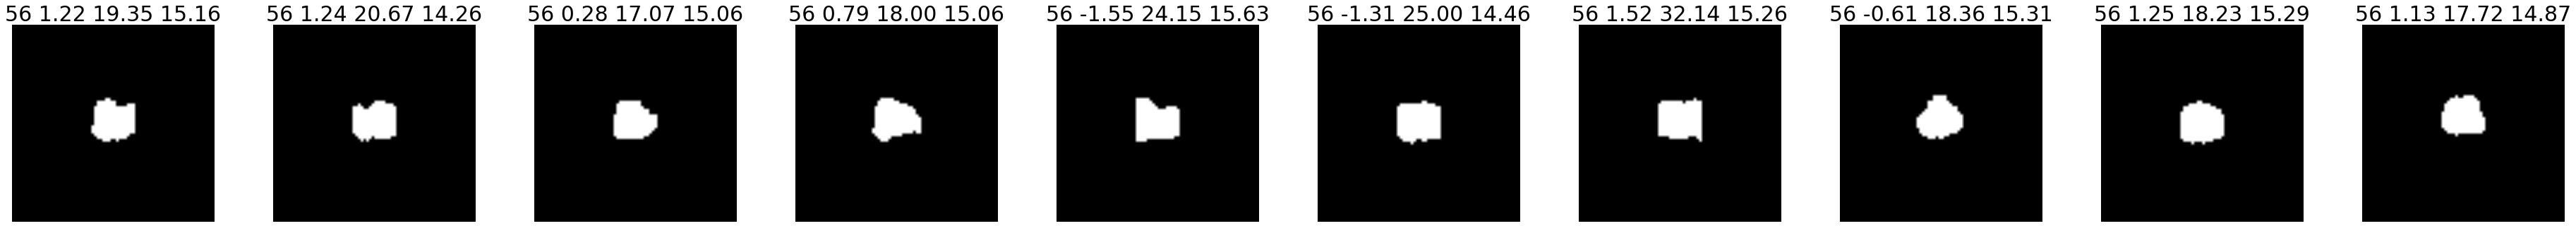

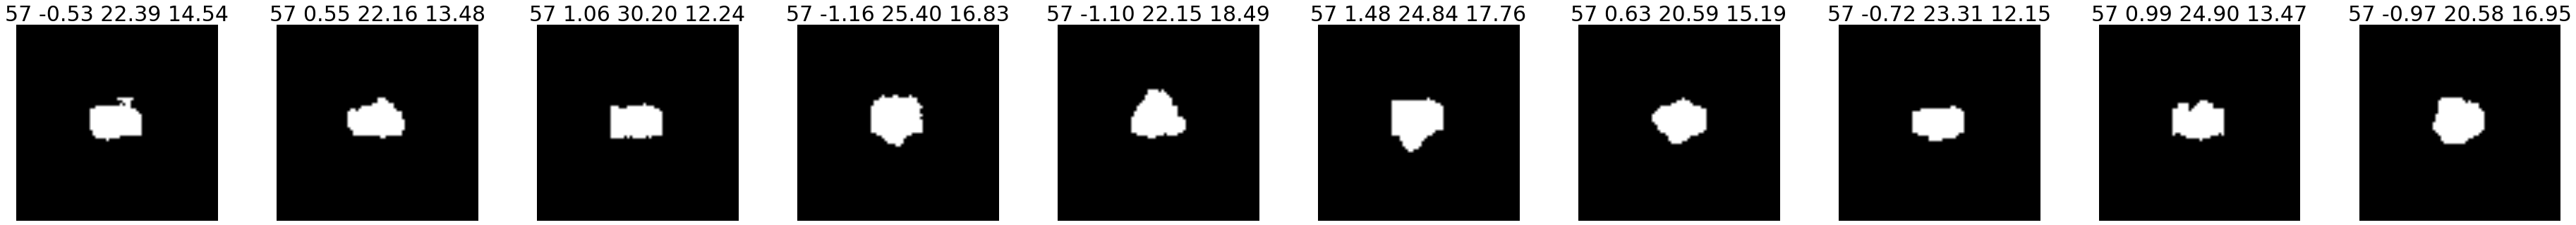

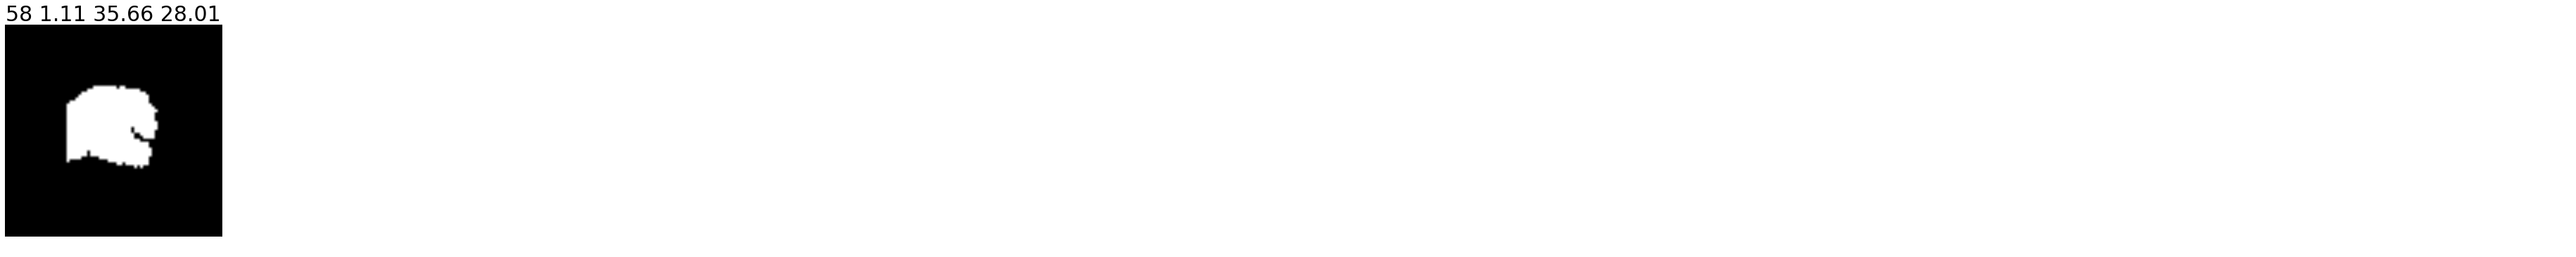

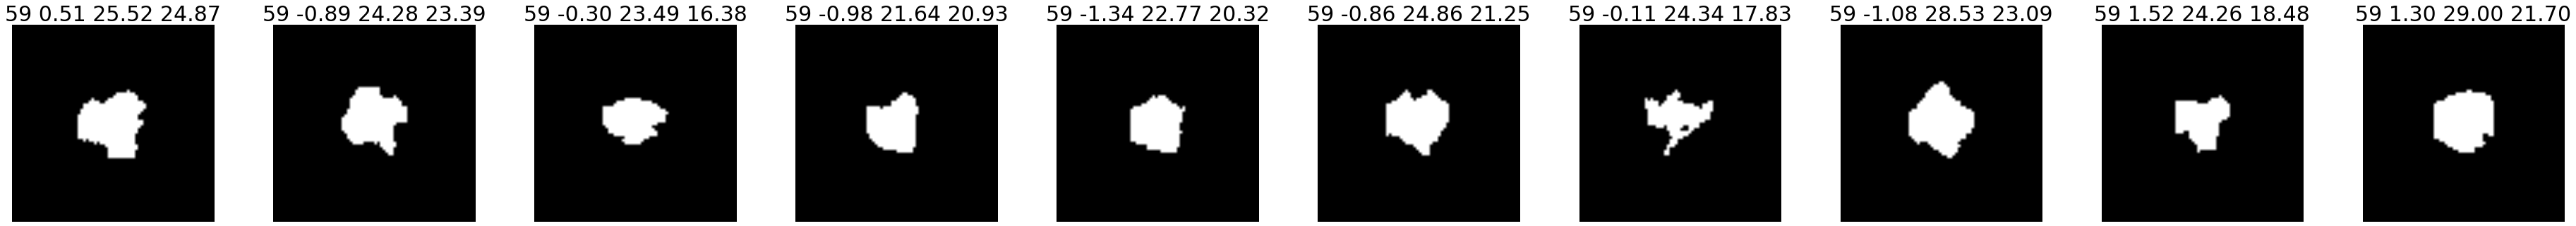

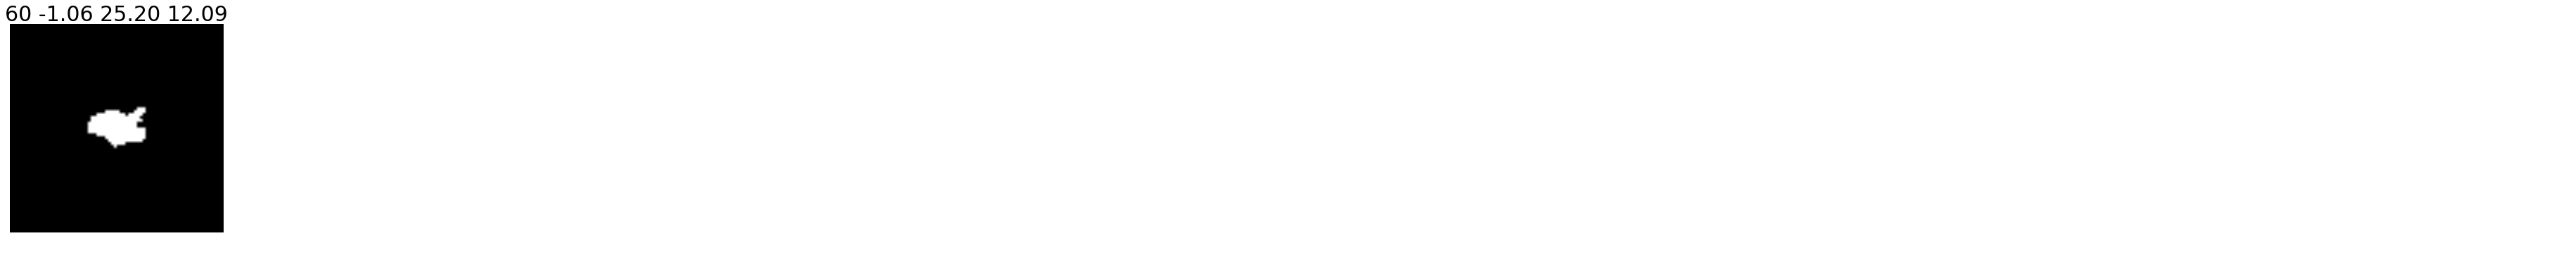

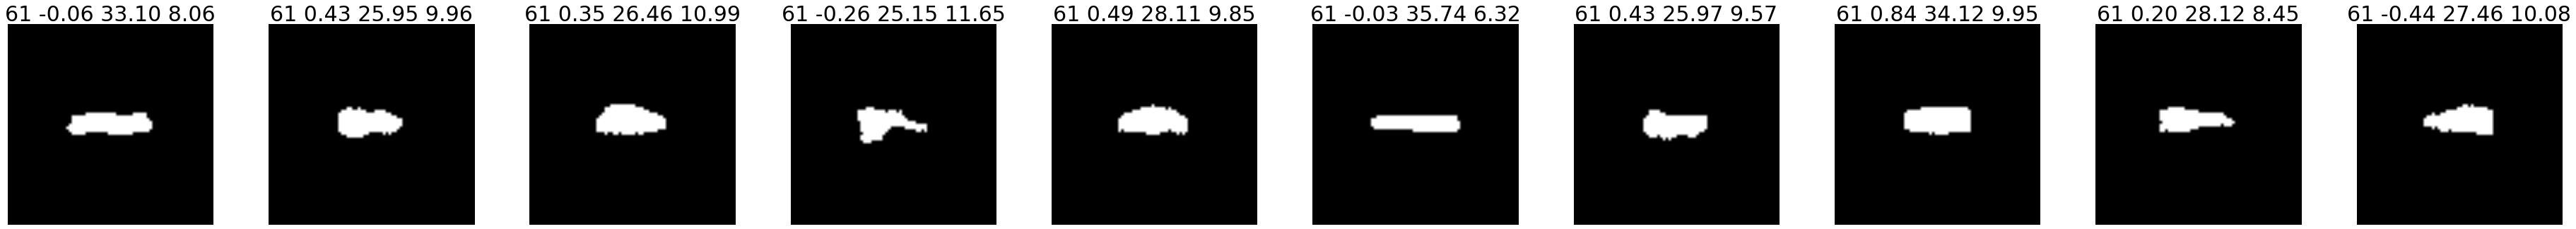

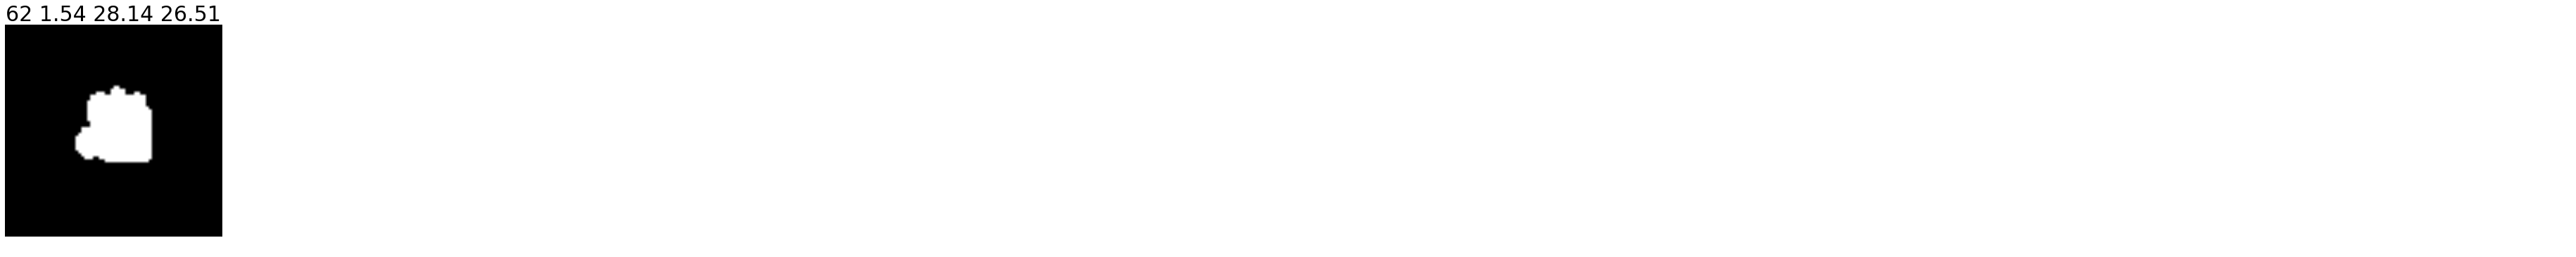

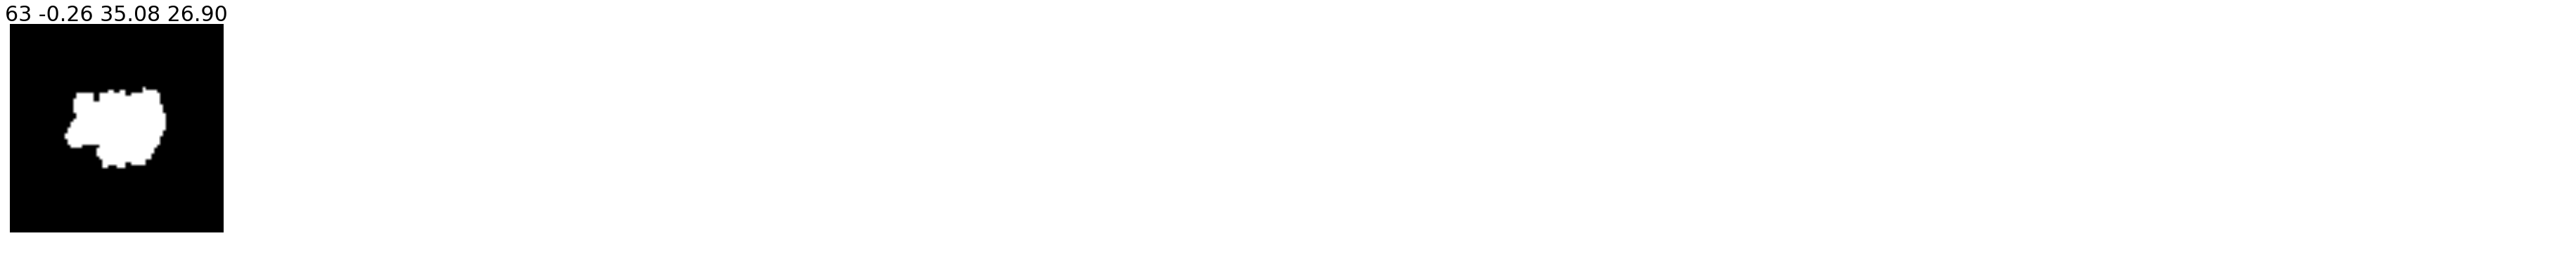

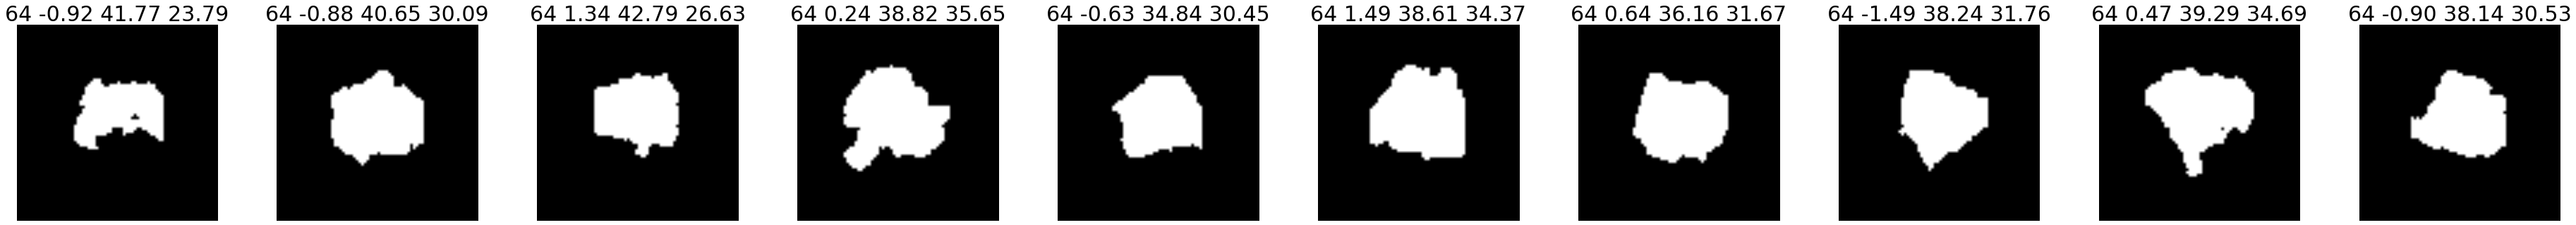

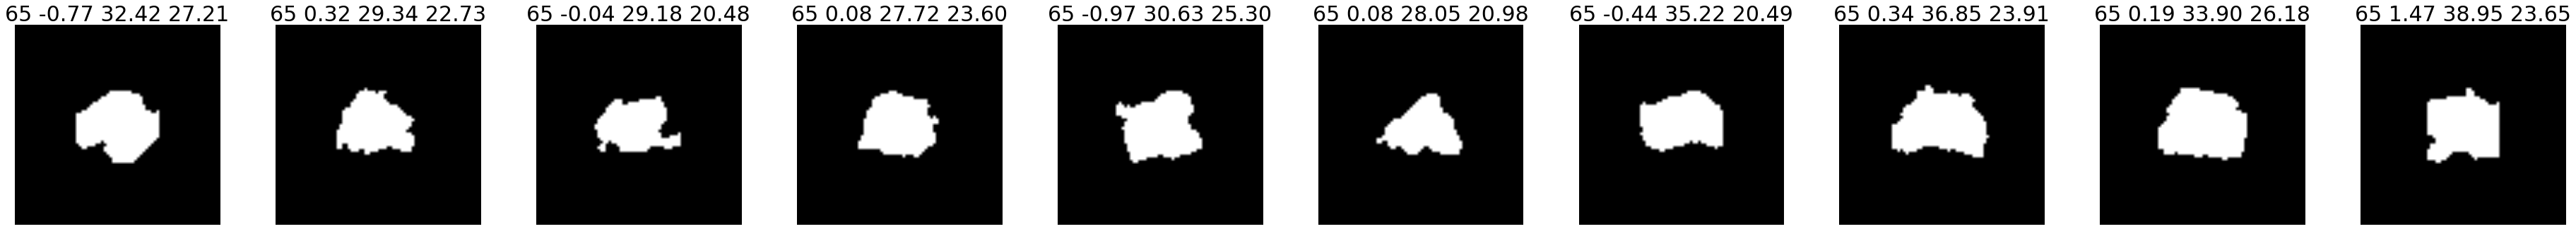

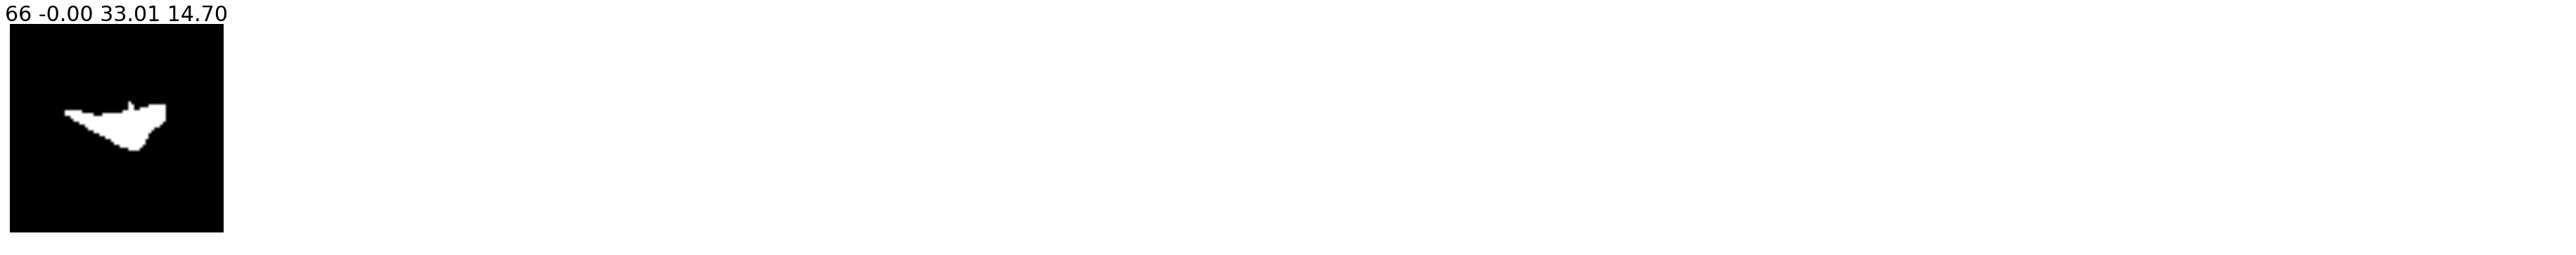

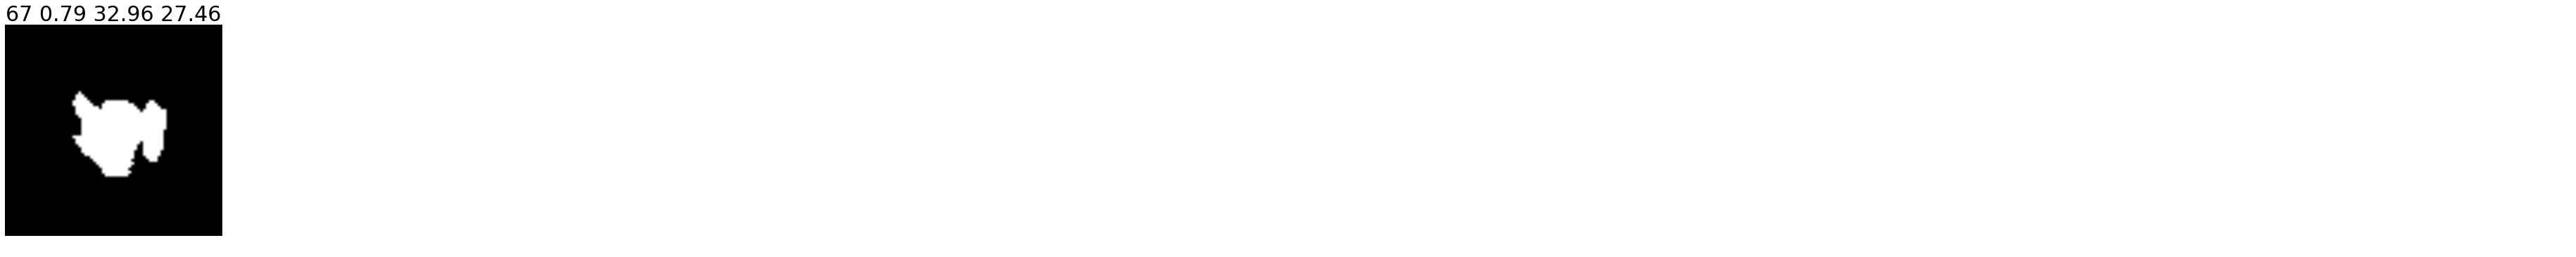

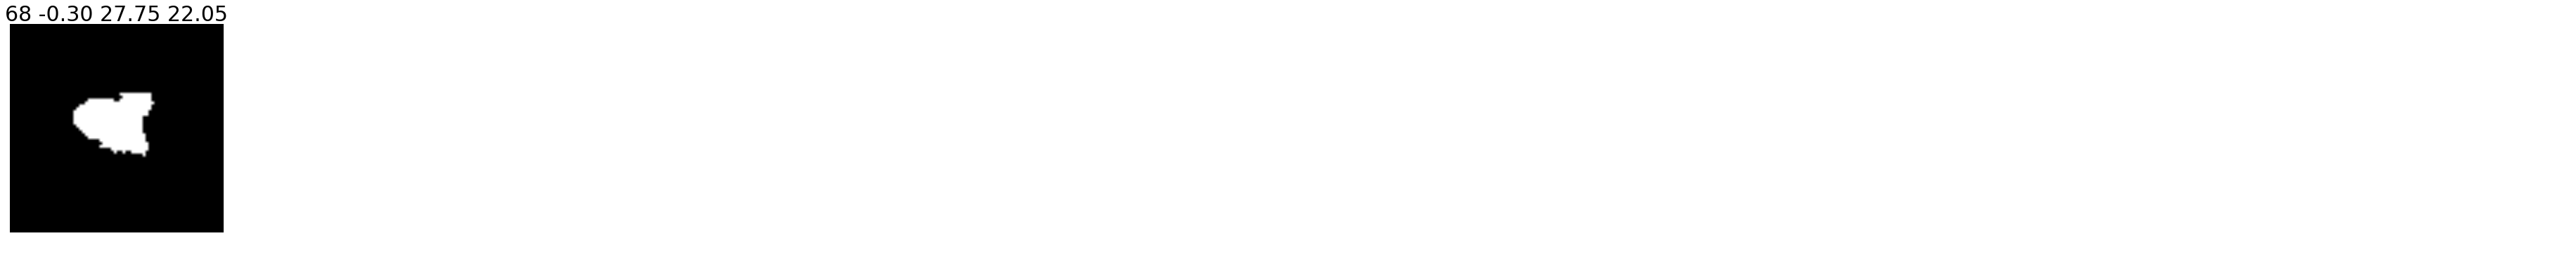

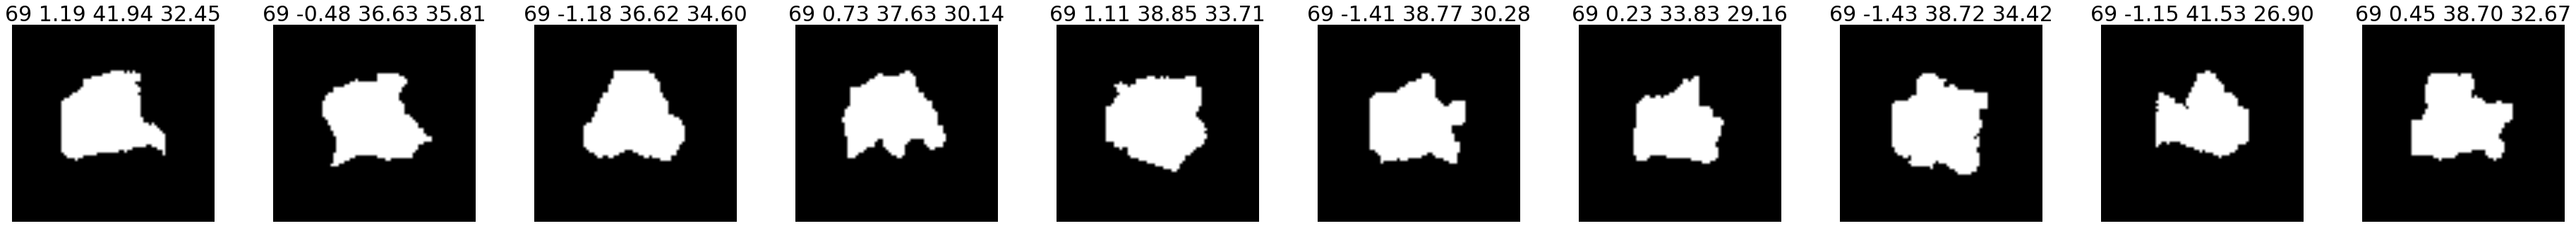

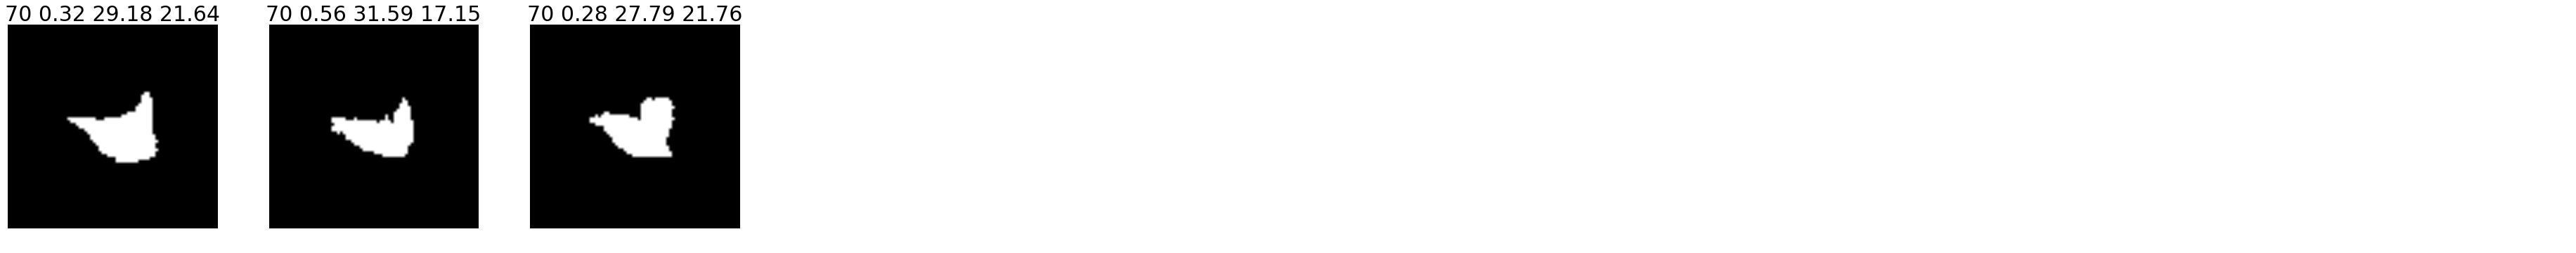

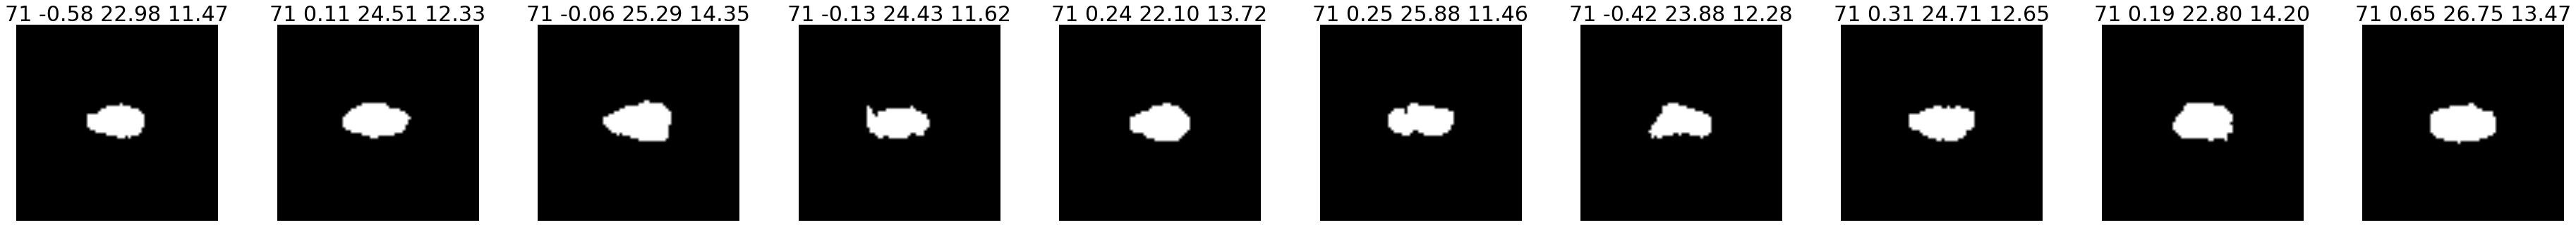

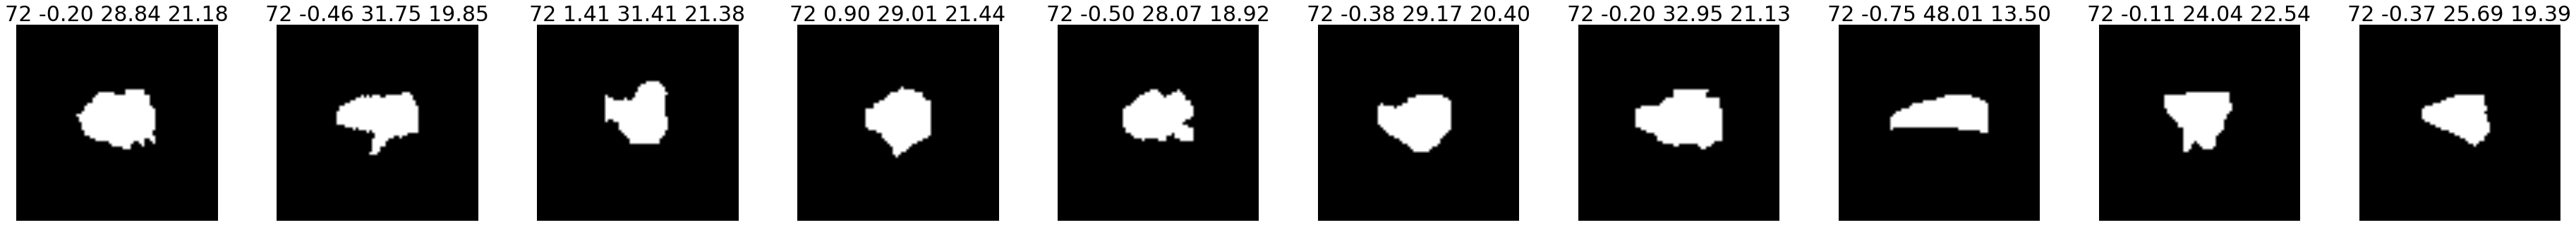

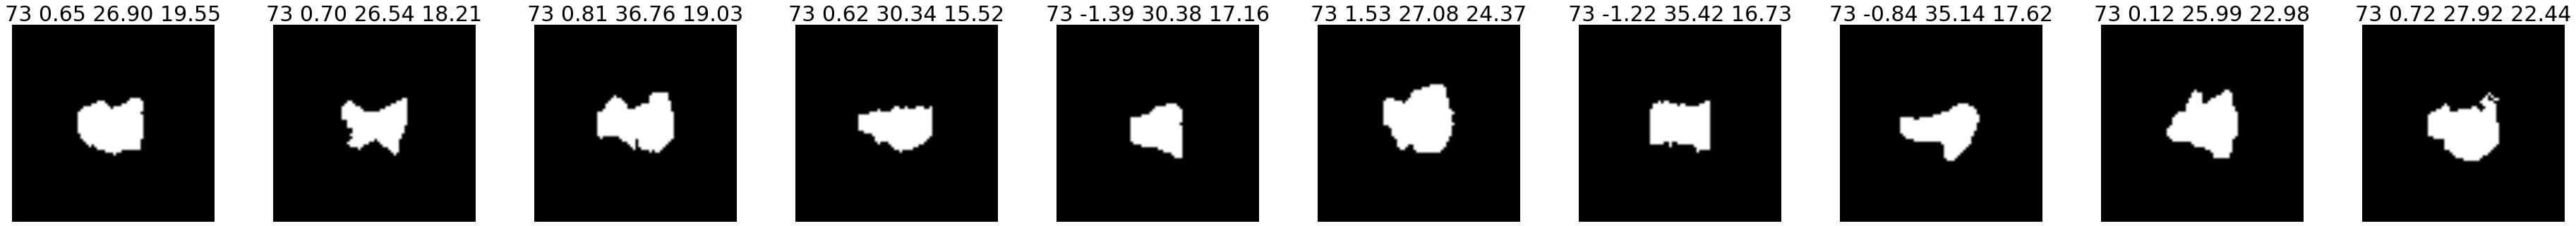

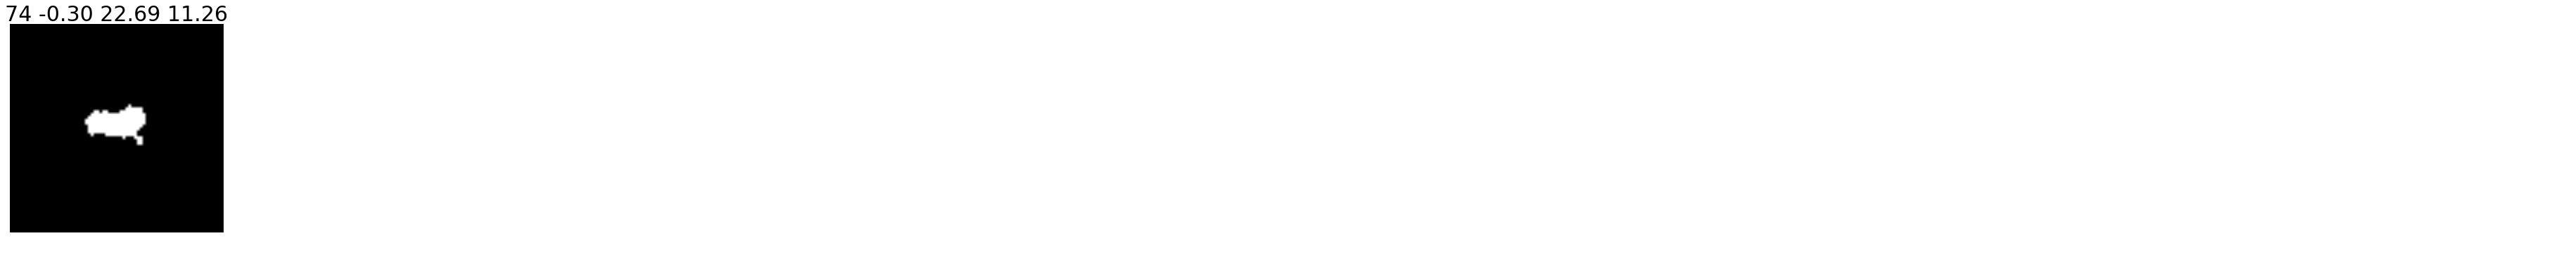

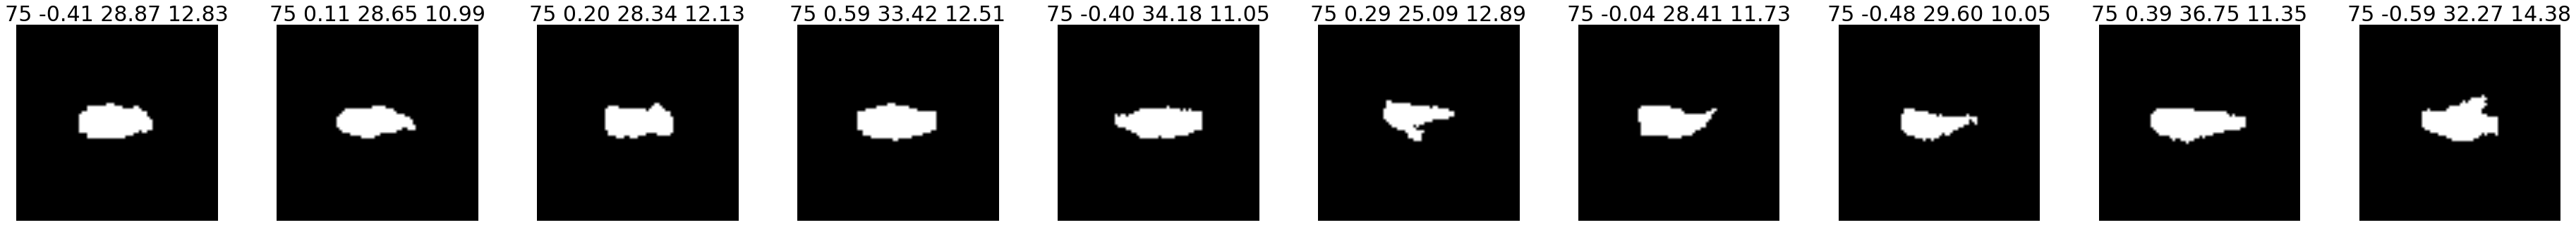

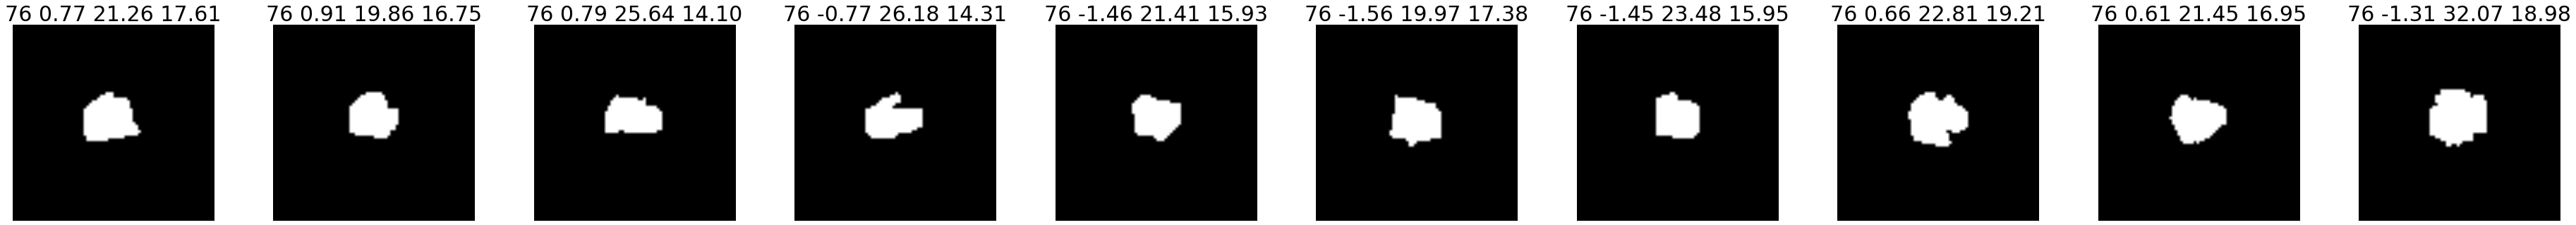

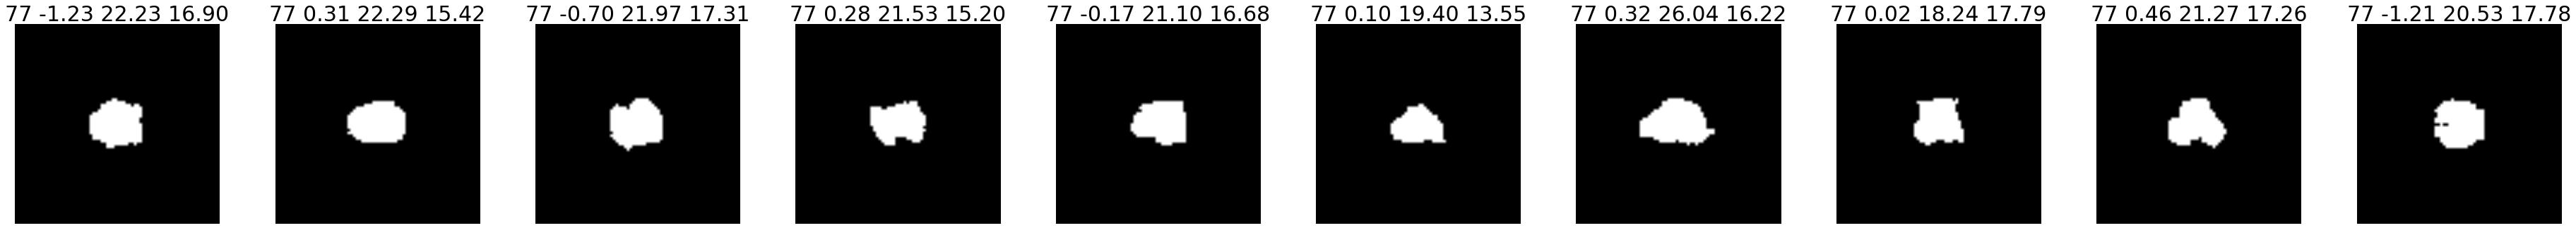

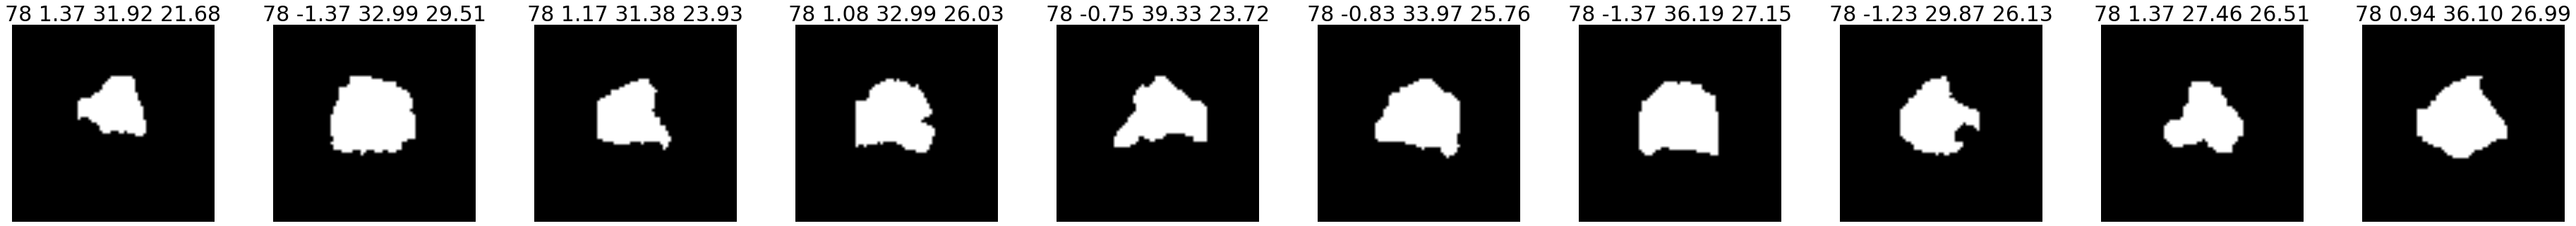

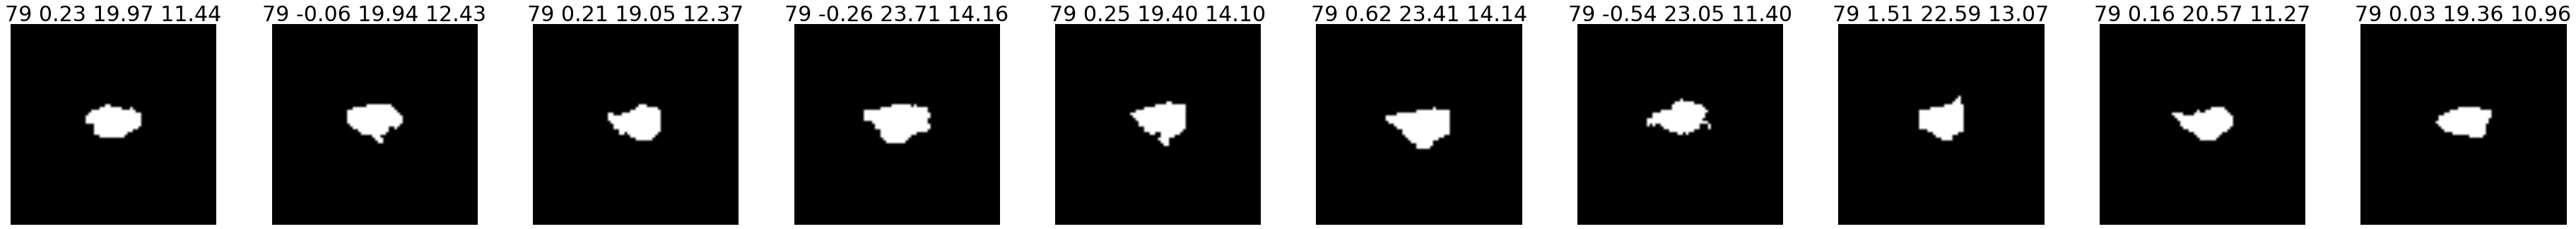

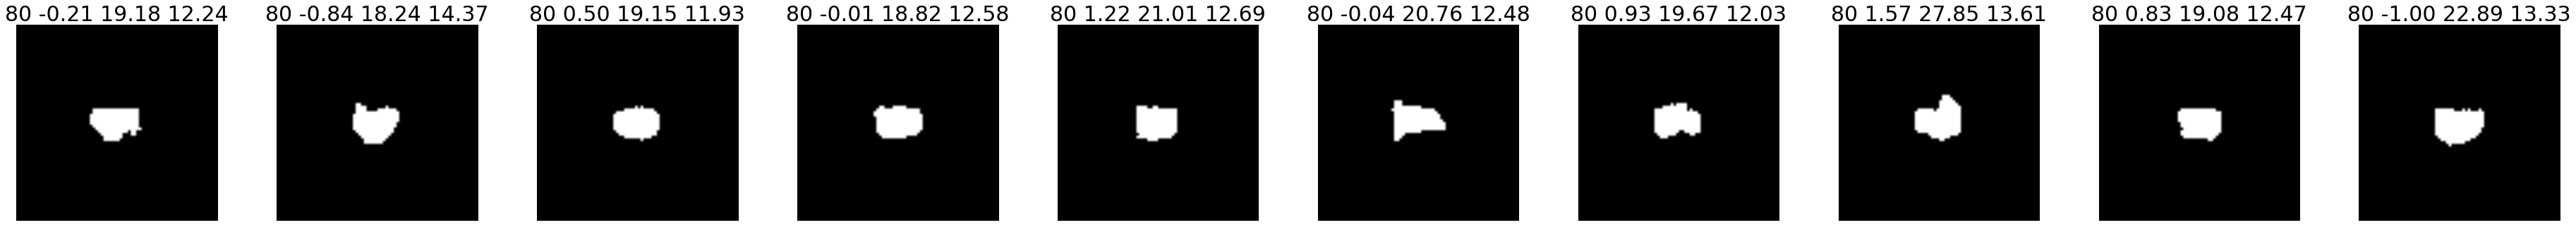

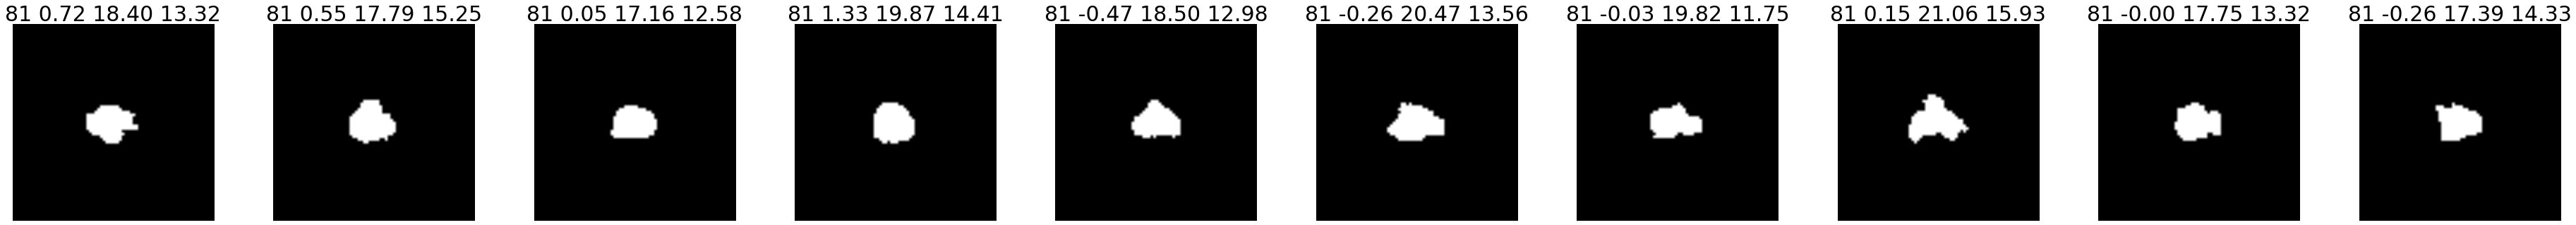

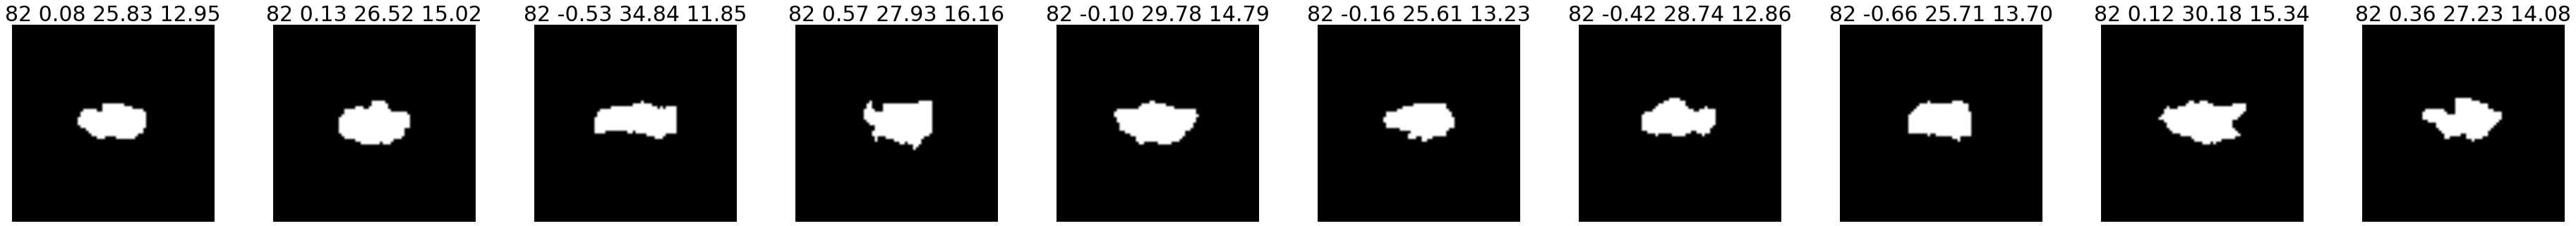

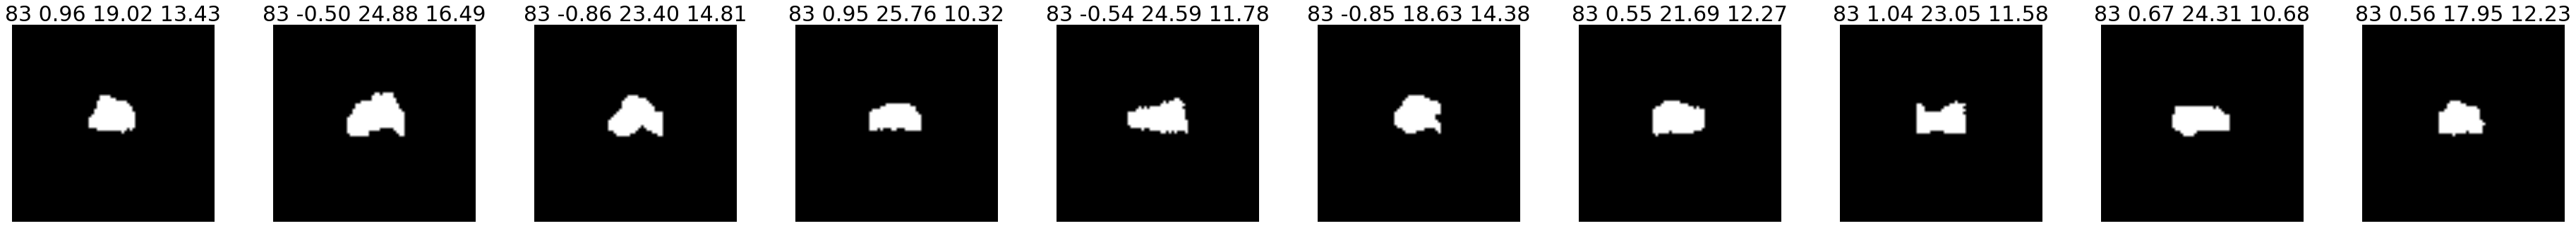

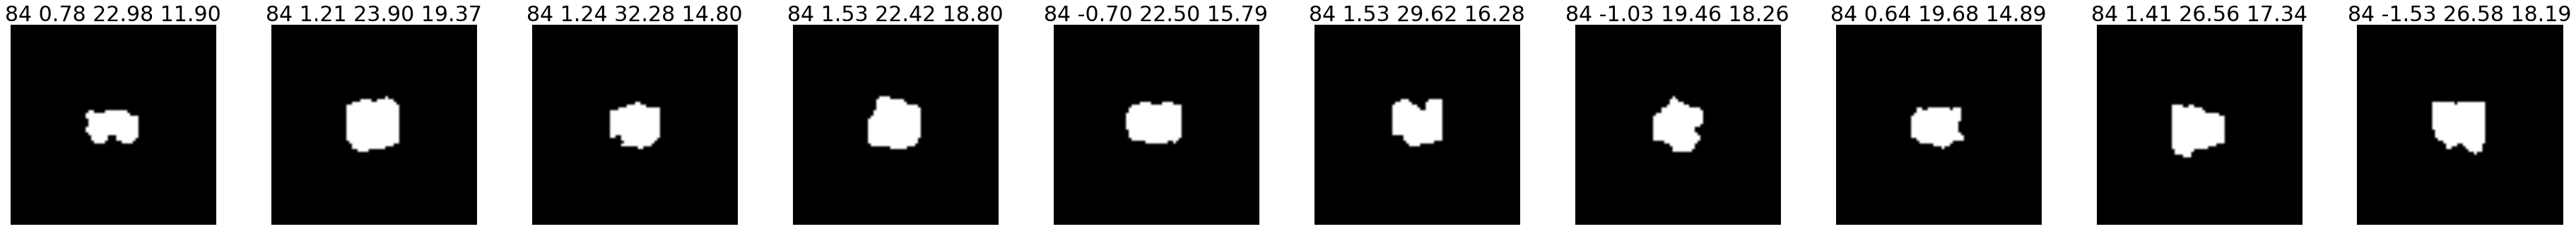

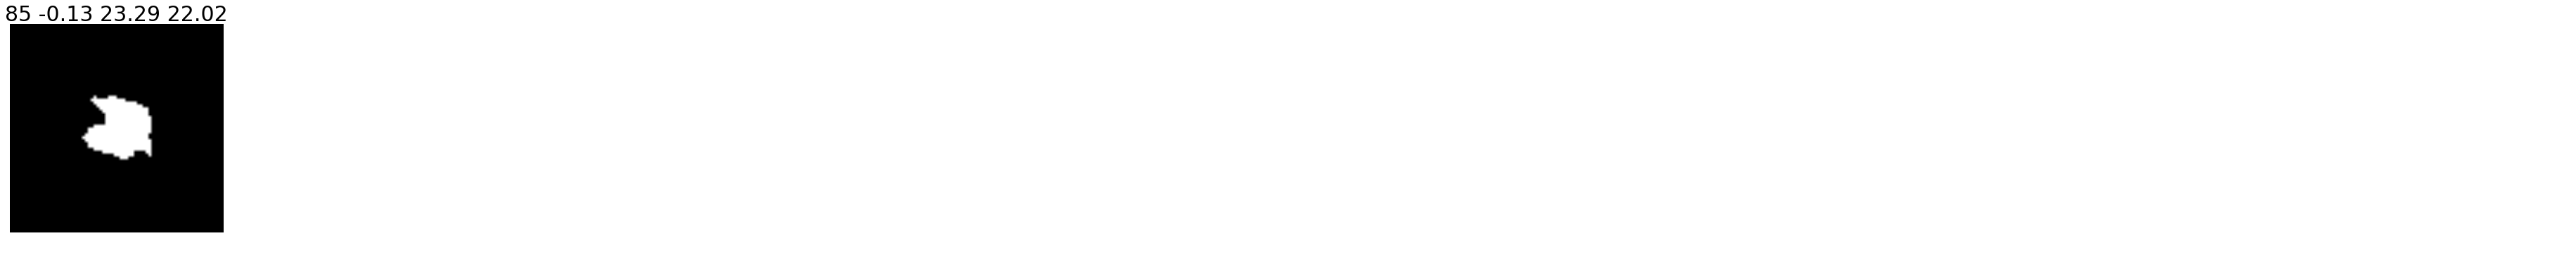

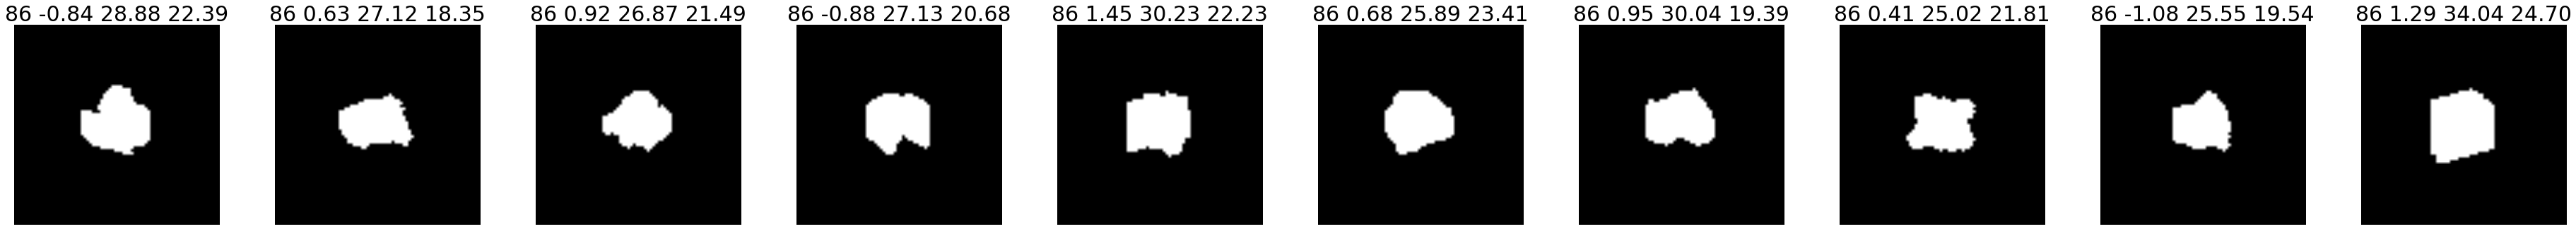

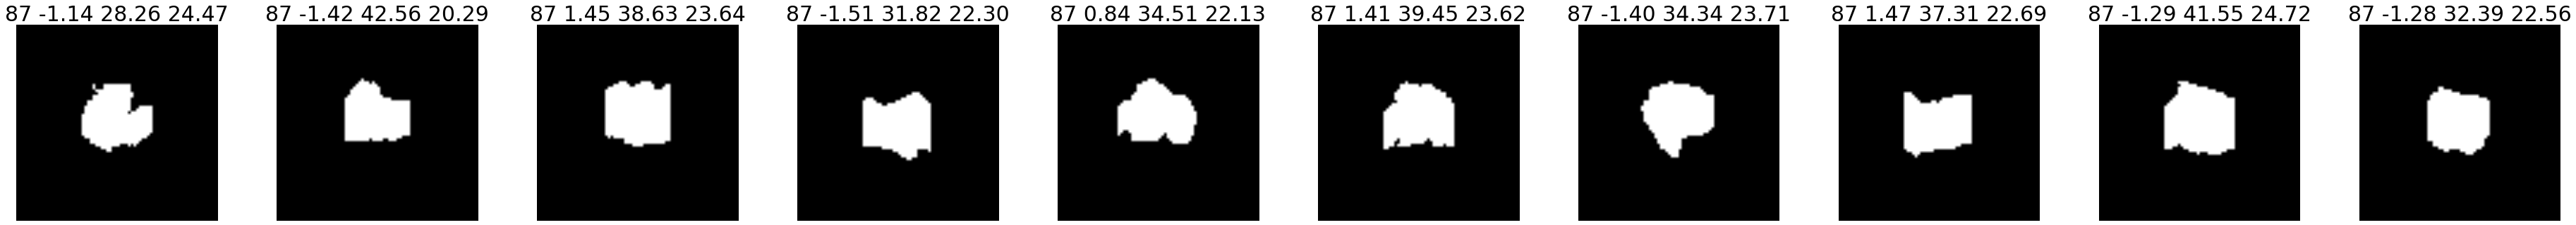

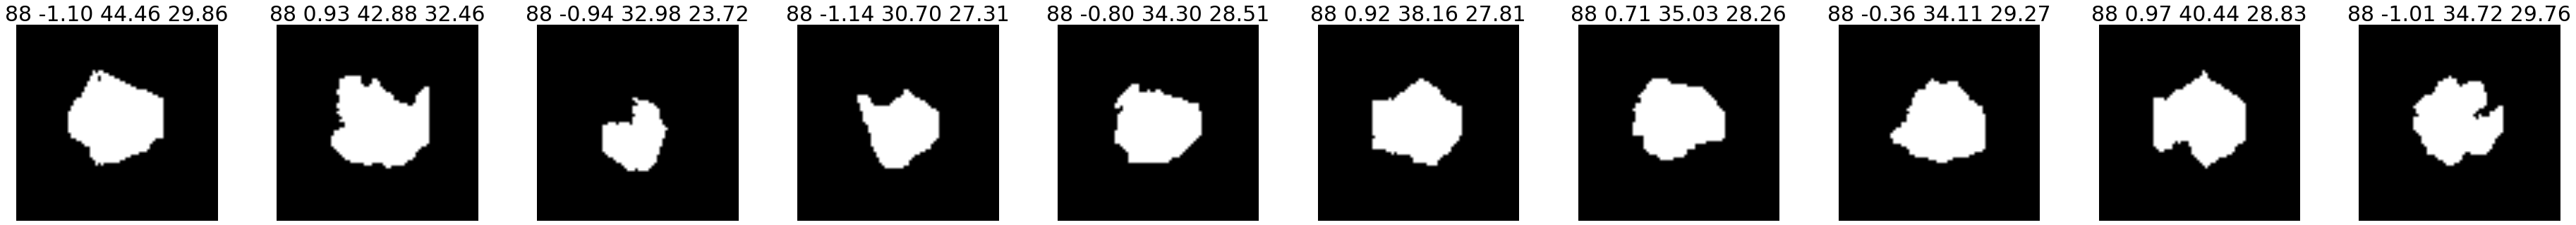

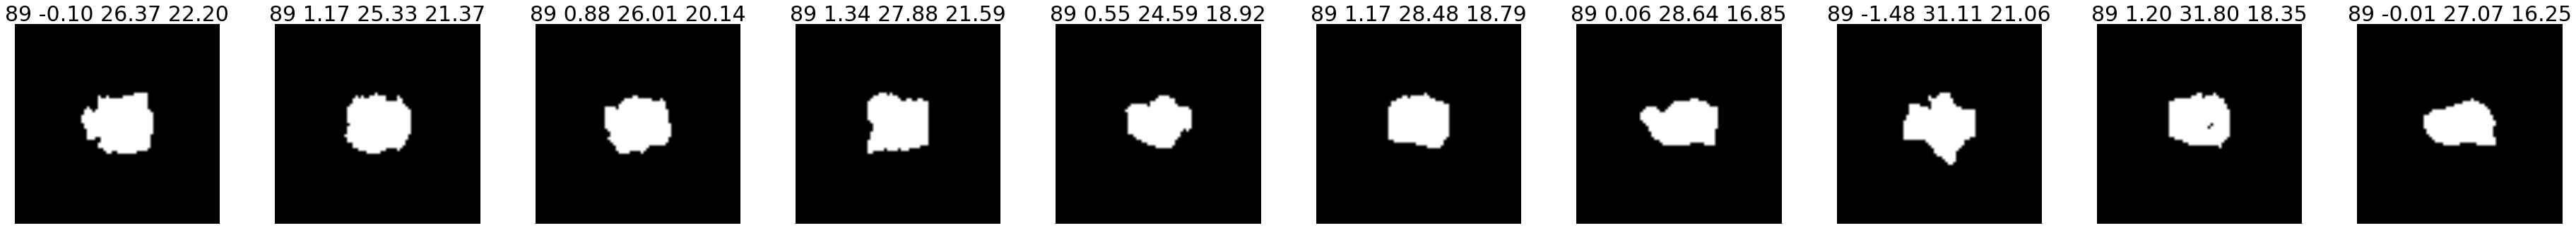

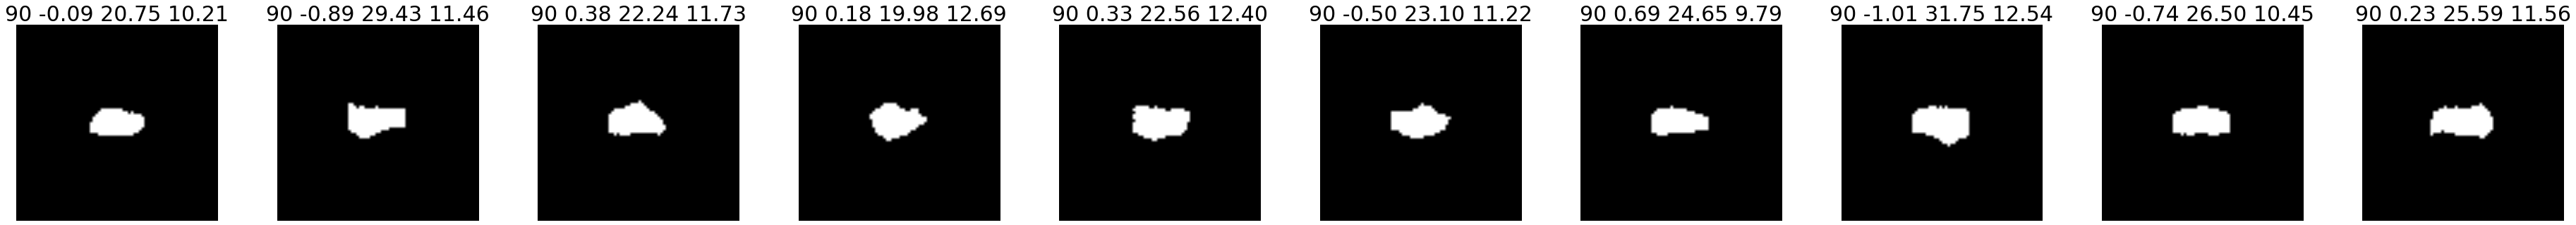

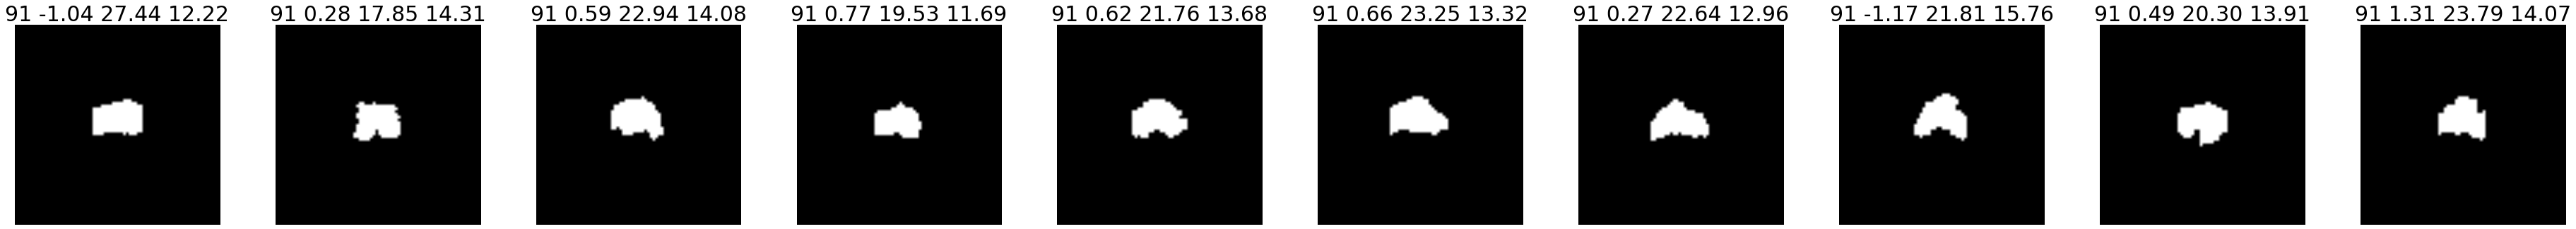

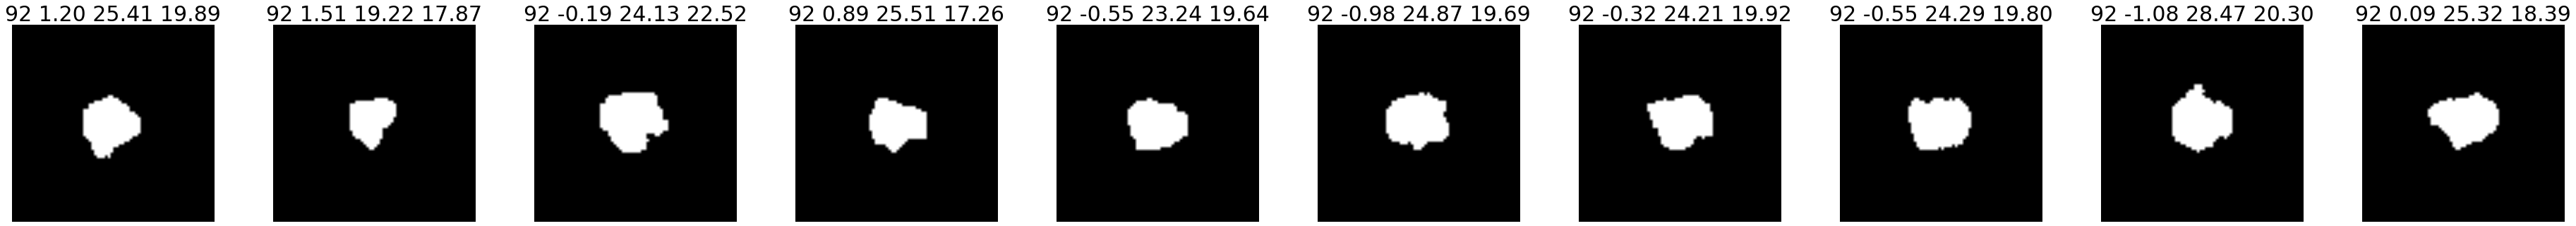

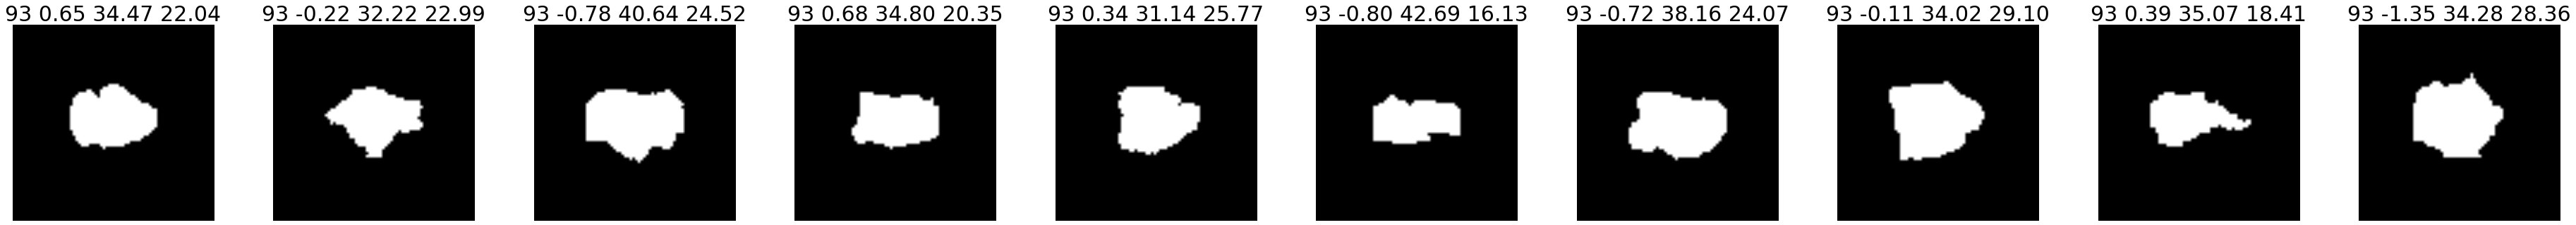

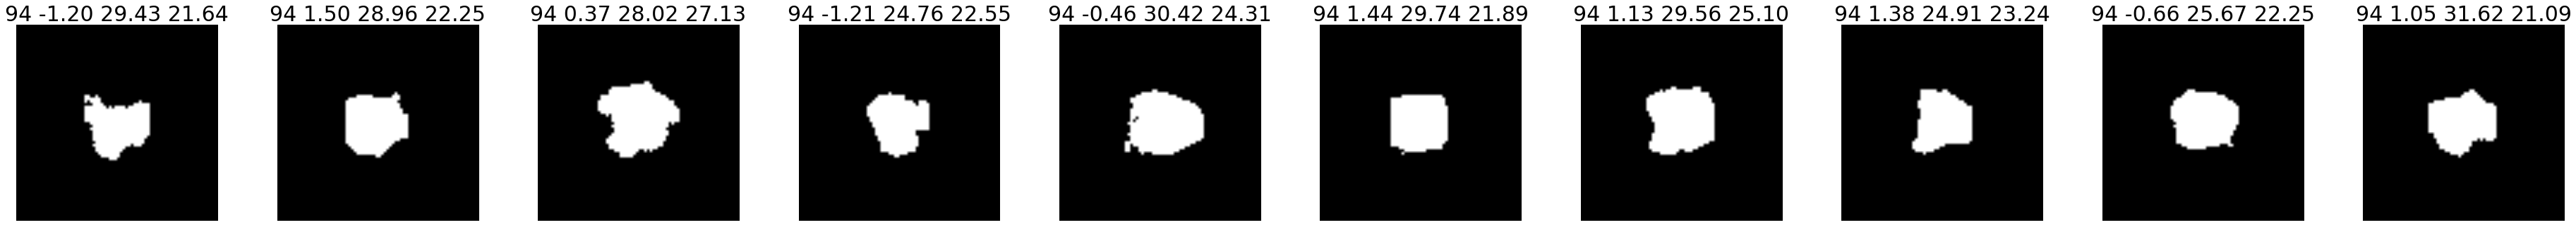

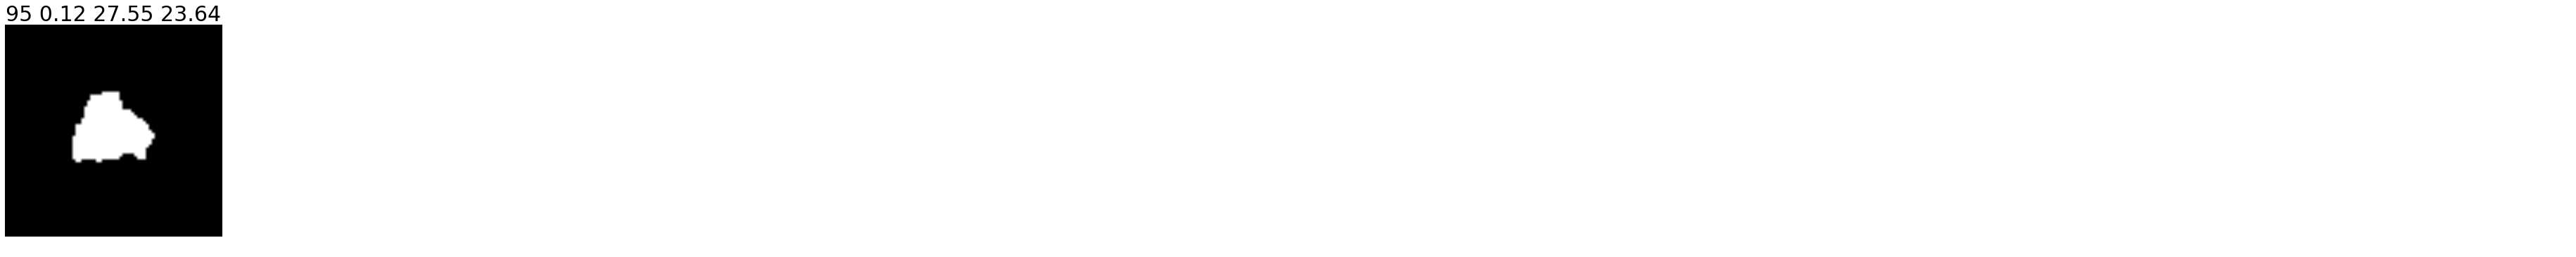

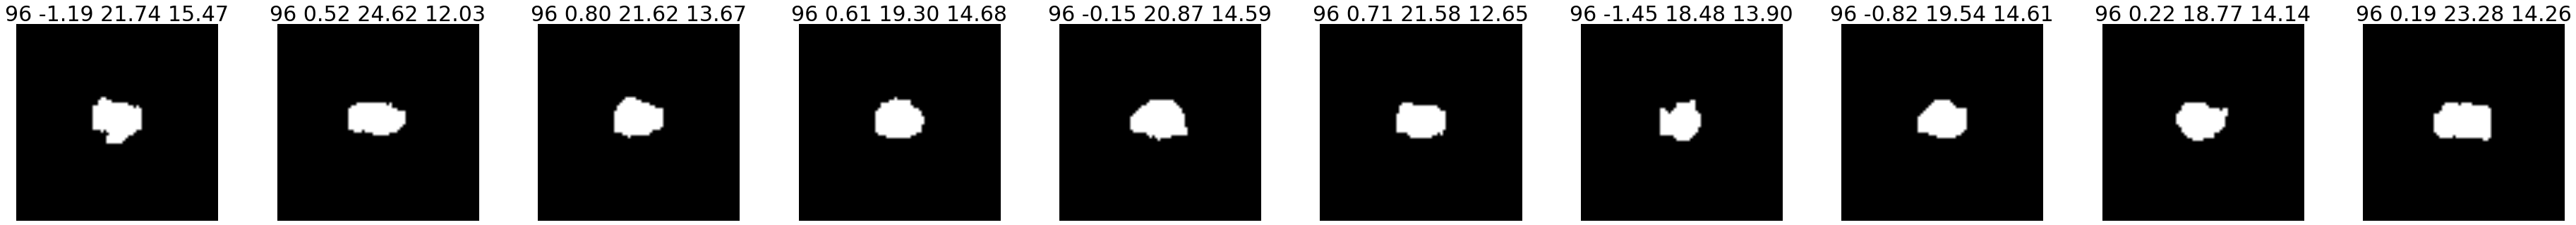

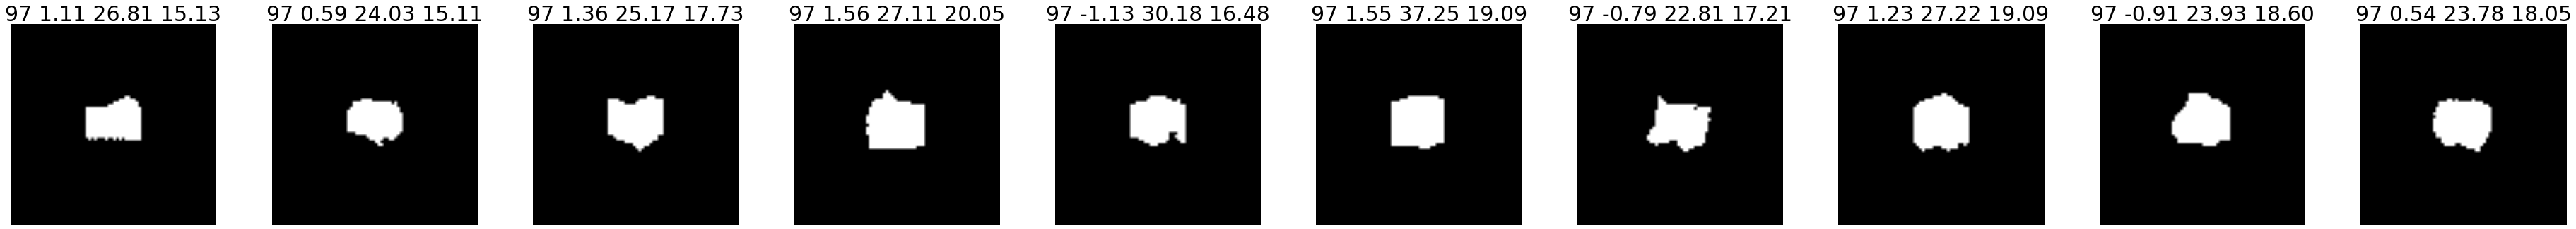

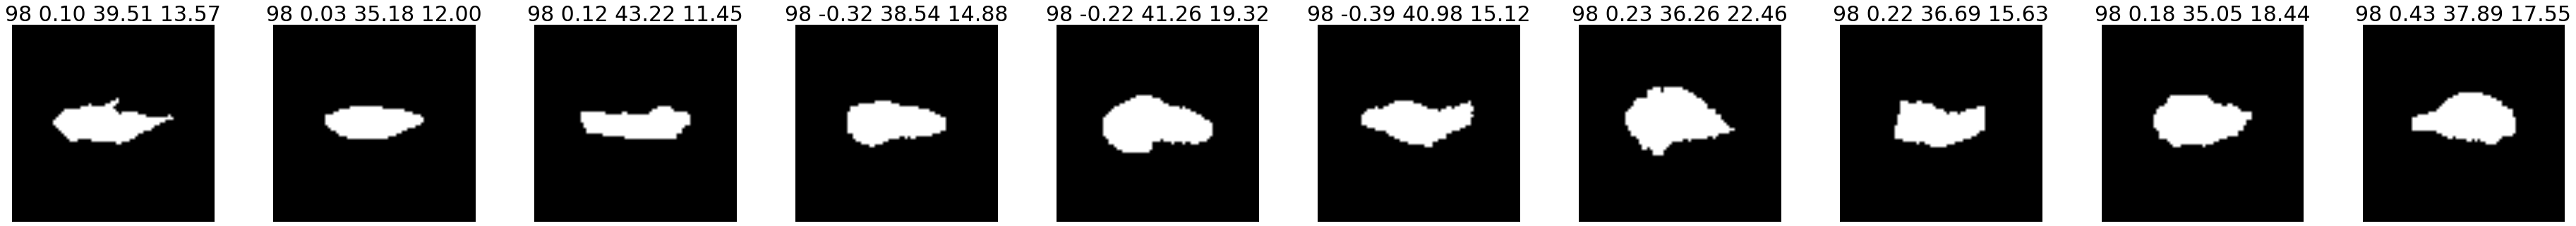

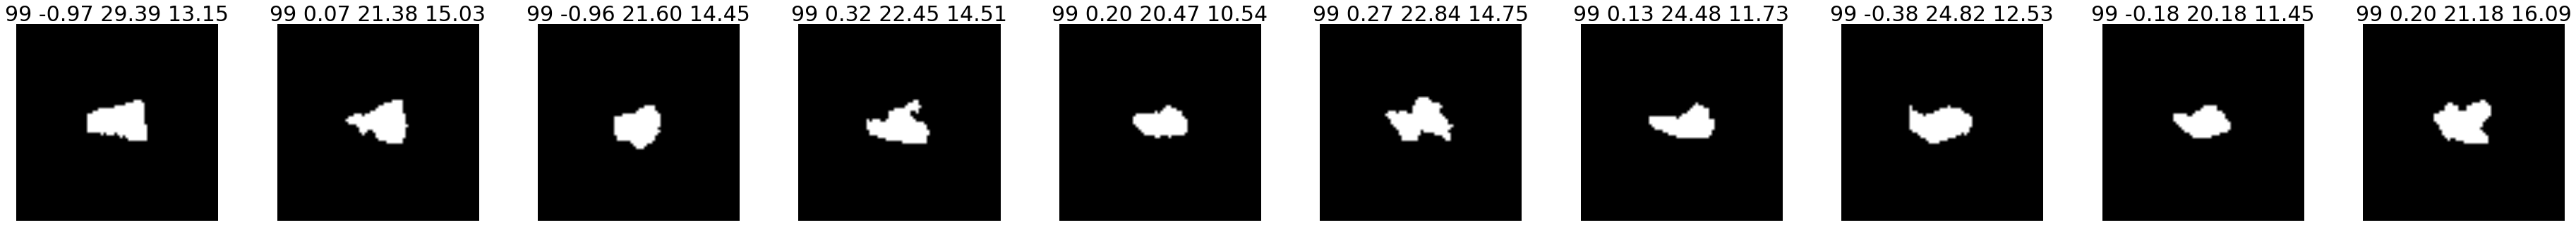

In [25]:
for c in range(len(kmeanspp_seeds)):
    
    indices = np.where(class_label == c)[0]
    sample_indices = np.random.choice(indices, min(len(indices), 10), replace=False)
    
    sample_cell_images = [dataset_cells_aligned_padded[i].reshape((cell_h, cell_w)) for i in sample_indices]
    
    titles = []
    for i in sample_indices:
        sec, idx = dataset_cell_addresses[i]
        title = '%d %.2f %.2f %.2f' % (c, cell_orientations[sec][idx], cell_majorAxisLens[sec][idx], cell_minorAxisLens[sec][idx])
        titles.append(title)
    
    display_images_in_grids(sample_cell_images, nc=10, titles=titles)

In [163]:
templates = []

for c in range(len(kmeanspp_seeds)):
    
    indices = np.where(class_label == c)[0]
    template = dataset_cells_aligned_padded[indices[0]].reshape((cell_h, cell_w))
    templates.append(template)

In [157]:
LARGE = 2
ELLIPSE = 0

In [154]:
cell_categories = ELLIPSE * np.ones((n_cells,), np.int)
cell_categories[dataset_cell_indices] = LARGE

In [172]:
large_descriptors = np.zeros((n_dataset_cells, 10))

for i in dataset_cell_indices:

    sec, idx = cell_addresses[i]
    
    center = cell_centers[sec][idx]
    orient = cell_orientations[sec][idx]
    
    idx_in_dataset = list(dataset_cell_indices).index(i)
    embedding_feature = embeddings[idx_in_dataset]
    large_descriptors[idx_in_dataset] = (center[0], center[1], orient) + tuple(embedding_feature[:7])

KeyboardInterrupt: 

In [167]:
descriptors = []

bar = show_progress_bar(0, n_cells-1)

for i in range(n_cells):
    
    bar.value = i

    sec, idx = cell_addresses[i]
    
    center = cell_centers[sec][idx]
    major_len = cell_majorAxisLens[sec][idx]
    minor_len = cell_minorAxisLens[sec][idx]
    orient = cell_orientations[sec][idx]
    
    if cell_categories[i] == ELLIPSE:
        descriptors.append((center, orient, major_len, minor_len))
    elif cell_categories[i] == LARGE:
        embedding_feature = embeddings[list(dataset_cell_indices).index(i)]
#         template_idx = class_label[list(dataset_cell_indices).index(i)]
        descriptors.append((center, orient, embedding_feature))

KeyboardInterrupt: 

In [31]:
cell_centers = {}

for sec in range(first_bs_section, last_bs_section, 50):
    fn = section_to_filename[sec]
#     coords = pickle.load(open('/home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD589/%(fn)s/%(fn)s_blobCoords.pkl' % {'fn': fn}, 'r'))
#     center = np.array([cs.mean(axis=0) for cs in coords])
    center = pickle.load(open('/home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD589/%(fn)s/%(fn)s_blobCentroids.pkl' % {'fn': fn}, 'r'))
    cell_centers[sec] = center

In [68]:
image_w, image_h = DataManager.get_image_dimension('MD589')

In [173]:
cell_image_dir = create_if_not_exists('/home/yuncong/csd395/CSHL_cells_v2/reconstructed_images/%(stack)s' %{'stack':stack})

In [174]:
stack = 'MD589'

In [177]:
# for sec in range(first_bs_section, last_bs_section, 50):

sec = 242

reconstructed_image = np.zeros((image_h, image_w, 3), np.uint8)

n = cell_centers[sec].shape[0]

for i in range(n):
    cv2.ellipse(reconstructed_image, tuple(cell_centers[sec][i][::-1].astype(np.int)), 
                (int(cell_majorAxisLens[sec][i]/2), int(cell_minorAxisLens[sec][i]/2)), 
                -np.rad2deg(cell_orientations[sec][i]), 0, 360, (255, 255, 255), -1)

fn = section_to_filename[sec]


img = imread(DataManager.get_image_filepath(stack, section=sec))



imsave(os.path.join(cell_image_dir, '%(fn)s_reconstructedImage.png' % {'stack':stack, 'fn': fn}), reconstructed_image)

MemoryError: 

In [178]:
img_reconstruction_overlaid = alpha_blending(img[5000:8000, 5000:8000], 
                                             reconstructed_image[5000:8000, 5000:8000], 
                                             .5,
                                             .5)

In [179]:
display_image(img_reconstruction_overlaid)

/oasis/projects/nsf/csd395/yuncong/Brain/cells/tmp.jpg

In [96]:
for sec in range(first_bs_section, last_bs_section, 50):
    
    reconstructed_image = np.zeros((image_h, image_w, 3), np.uint8)

    n = cell_centers[sec].shape[0]

#     for i in np.random.choice(range(n), 10000, replace=False):
    for i in range(n):
        
        if i in dataset_cell_indices['large']:
            template = 
            
            
        elif i in dataset_cell_indices['ellipsoid']:
            
            cv2.ellipse(reconstructed_image, tuple(cell_centers[sec][i][::-1].astype(np.int)), 
                        (int(cell_majorAxisLens[sec][i]/2), int(cell_minorAxisLens[sec][i]/2)), 
                        np.rad2deg(cell_orientations[sec][i]), 0, 360, (255, 255, 255), -1)
            
        elif i in dataset_cell_indices['spherical']:
            
            cv2.circle(reconstructed_image, tuple(cell_centers[sec][i][::-1].astype(np.int)), 
                       int(cell_majorAxisLens[sec][i]/2), (255, 255, 255), -1)
            
 
    fn = section_to_filename[sec]
    imsave(os.path.join(cell_image_dir, '%(fn)s_reconstructedImage.png' % {'stack':stack, 'fn': fn}), reconstructed_image)

In [75]:
display_image(reconstructed_image)

/oasis/projects/nsf/csd395/yuncong/Brain/cells/tmp.jpg